In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter
import statistics
from scipy.stats import skew 
import math as m
plt.style.use('seaborn')
plt.style.use('seaborn-talk')

In [2]:
pd.set_option('display.max_columns', 50)

# Note that the total_data is out of order, it's participants 1 through 15, then participant 22, then participants
# 16 through 29 in the csv. 

total_data = pd.read_csv('total_participant_data.csv')

In [3]:
# drop the empty columns
total_data.drop(columns=['FixationFilter', 'CamLeftX', 'CamLeftY', 'CamRightX', 'CamRightY'], inplace=True)
total_data.drop(columns=['IRMarkerCount', 'IRMarkerID', 'PupilGlassesRight'], inplace=True)

# rename certain columns
total_data.rename(columns={'GazePointX (ADCSpx)': 'gen_gazeX', 'GazePointY (ADCSpx)': 'gen_gazeY'}, inplace=True)

In [4]:
# You can see that the recording names are all 'Rec 01', but for some reason P03 has the recording name 
# 'Participant_2', P14 has the recording name 'Rec 03', and P22 has the recording name 'Rec01'
# I think we can drop the RecordingName column

# total_data.groupby('ParticipantName').RecordingName.unique()
# total_data.RecordingName.unique()

# Drop the RecordingName column
total_data.drop(columns=['RecordingName'], inplace=True)

In [5]:
total_data

,ParticipantName,RecordingDate,MediaName,RecordingTimestamp,FixationIndex,GazeEventType,GazeEventDuration,gen_gazeX,gen_gazeY,GazePointLeftX (ADCSpx),GazePointLeftY (ADCSpx),GazePointRightX (ADCSpx),GazePointRightY (ADCSpx),FixationPointX (MCSpx),FixationPointY (MCSpx),GazePointX (MCSpx),GazePointY (MCSpx),DistanceLeft,DistanceRight,EyePosLeftX (ADCSmm),EyePosLeftY (ADCSmm),EyePosLeftZ (ADCSmm),EyePosRightX (ADCSmm),EyePosRightY (ADCSmm),EyePosRightZ (ADCSmm),ValidityLeft,ValidityRight,PupilLeft,PupilRight,SaccadeIndex
0,P01,11/4/2019,NaN,12.0,NaN,Unclassified,8.0,645.0,448.0,578.0,435.0,712.0,462.0,NaN,NaN,NaN,NaN,596.49,596.49,146.82,133.73,589.20,200.72,130.35,591.33,0.0,0.0,5.49,5.38,NaN
1,P01,11/4/2019,NaN,29.0,1.0,Fixation,733.0,644.0,452.0,579.0,437.0,710.0,467.0,NaN,NaN,NaN,NaN,596.52,596.52,146.81,133.75,589.23,200.71,130.36,591.30,0.0,0.0,5.49,5.38,NaN
2,P01,11/4/2019,NaN,46.0,1.0,Fixation,733.0,644.0,451.0,575.0,438.0,713.0,464.0,NaN,NaN,NaN,NaN,596.49,596.49,146.81,133.75,589.19,200.70,130.34,591.16,0.0,0.0,5.48,5.39,NaN
3,P01,11/4/2019,NaN,62.0,1.0,Fixation,733.0,646.0,451.0,579.0,440.0,713.0,463.0,NaN,NaN,NaN,NaN,596.42,596.42,146.82,133.73,589.12,200.70,130.32,591.12,0.0,0.0,5.49,5.38,NaN
4,P01,11/4/2019,NaN,79.0,1.0,Fixation,733.0,645.0,452.0,580.0,441.0,711.0,464.0,NaN,NaN,NaN,NaN,596.25,596.25,146.84,133.68,588.97,200.72,130.33,591.22,0.0,0.0,5.47,5.38,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888472,P29,12/6/2019,NaN,730993.0,NaN,Saccade,50.0,907.0,95.0,881.0,83.0,933.0,108.0,NaN,NaN,NaN,NaN,652.29,652.29,145.54,148.64,642.97,206.17,152.90,642.30,0.0,0.0,4.33,3.97,2294.0
1888473,P29,12/6/2019,NaN,731010.0,NaN,Saccade,50.0,1132.0,43.0,1124.0,25.0,1141.0,62.0,NaN,NaN,NaN,NaN,652.68,652.68,146.06,148.76,643.35,206.63,153.07,642.97,0.0,0.0,4.30,3.97,2294.0
1888474,P29,12/6/2019,NaN,731026.0,NaN,Unclassified,25.0,1155.0,42.0,1153.0,26.0,1157.0,59.0,NaN,NaN,NaN,NaN,652.26,652.26,146.11,148.62,642.96,206.69,152.96,642.69,0.0,0.0,4.37,4.00,NaN
1888475,P29,12/6/2019,NaN,731043.0,NaN,Unclassified,25.0,1150.0,46.0,1153.0,31.0,1148.0,62.0,NaN,NaN,NaN,NaN,652.24,652.24,146.10,148.61,642.95,206.71,152.94,642.71,0.0,0.0,4.35,4.00,NaN


In [6]:
# Fix the mistakes in the ParticipantName column
def fix_participant_names(entry):
    if entry == 'P09':
        return 'P08'
    elif entry == 'P9':
        return 'P09'
    else:
        return entry

total_data.ParticipantName = total_data.ParticipantName.map(fix_participant_names)

In [7]:
# Replace the gen_gazeX and gen_gazeY entries for participant 12 with the left eye data because - due to participant
# 12's lazy right eye - the right eye calibration was way off

total_data.gen_gazeX = np.where(total_data.ParticipantName == 'P12', total_data['GazePointLeftX (ADCSpx)'], \
                                total_data.gen_gazeX)

total_data.gen_gazeY = np.where(total_data.ParticipantName == 'P12', total_data['GazePointLeftY (ADCSpx)'], \
                                total_data.gen_gazeY)

In [8]:
# change the media names to just be the order of the letters/numbers from middle left going clockwise
def change_media_name(media_name):
        # clever way to check for Nan (if Nan then keep it as Nan)
        if media_name != media_name:
            return media_name
        # if not Nan, then remove the '.tiff' and the 'anagram_' from the MediaName
        else:
            return media_name.rstrip('.tiff').lstrip('anagram_')

total_data.MediaName = total_data.MediaName.map(change_media_name)

In [9]:
# fix the exceptions in the MediaName entries
def fix_media_name_exceptions(media_name):
    if media_name == '5_anagram_12345':
        return '12345'
    elif media_name == '6_anagram_123456':
        return '123456'
    elif media_name == 'Black Screen.jpg':
        return 'black_break_image'
    else:
        return media_name

total_data.MediaName = total_data.MediaName.map(fix_media_name_exceptions)

In [10]:
# Replace Nan in MediaName with 'none'

total_data.MediaName = total_data.MediaName.fillna('none')

In [11]:
# Show all the media names that were used. Note that the letters/numbers appeared from middle left going clockwise.
# This is explained later in this notebook. 

# total_data.MediaName.unique()

In [12]:
# We get these manual removes from looking at the histograms of the fixation data and the 
# recording_data (later on)

manual_remove = ['EATCJK', 'EUKMPA', 'GNSOAL', 'MLRNAO', 'YSMOTR', 'TENUAP', 'UMKPAE', 'RWBON', 'WRNOB', 'NPTAUE', 'RSOYMT', 'LOMNAR']    


total_data = total_data.loc[~total_data.MediaName.isin(manual_remove)]

ParticipantName
P19    3.442020
P16    1.766279
P15    0.719301
P03    0.617451
P26    0.601106
P14    0.478443
P23    0.459192
P13    0.443917
P09    0.393745
P01    0.352290
P07    0.348429
P22    0.303804
P10    0.298931
P25    0.298650
P29    0.293013
P17    0.227329
P02    0.227001
P20    0.223222
P11    0.203371
P28    0.201545
P06    0.175021
P12    0.161778
P27    0.157493
P08    0.144723
P21    0.132226
P24    0.126541
P05    0.116933
P18    0.106925
P04    0.097497
Name: ValidityLeft, dtype: float64

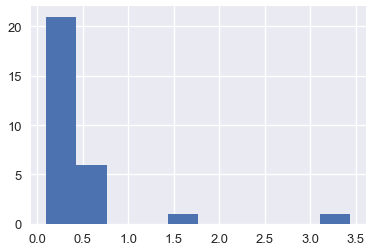

In [13]:
"""
ValidityLeft indicates the confidence level that the left eye has been correctly identified. The values range from 0
(high confidence) to 4 (eye not found). ValidityRight does the same for the right eye. 

As can be seen in the histograms for ValidityLeft and ValidityRight, most participants have average validities below 
0.5 for their left and right eyes. Participant 19's validity is an extreme outlier at around 3.5, and therefore 
that participant's data cannot be used. Participant 16 probably shouldn't be used either because their validity 
was around 1.76. Participants 15, 3, and 26 are at 0.7, 0.6, and 0.6, respectively. They're probably on the margin 
in terms of usability. Participants 4, 18, and 5 have the best (lowest) validities. 
"""

# show the average validities for the left eye for each participant, optionally run the histogram command

total_data.groupby(['ParticipantName']).ValidityLeft.mean().sort_values(ascending=False).hist()
left_validity = total_data.groupby(['ParticipantName']).ValidityLeft.mean().sort_values(ascending=False)
left_validity

ParticipantName
P19    3.306102
P16    1.760493
P15    0.662615
P03    0.603533
P26    0.584915
P23    0.539445
P14    0.478653
P13    0.419186
P09    0.413557
P01    0.363031
P07    0.345228
P10    0.308257
P22    0.307235
P29    0.301970
P25    0.281534
P20    0.256810
P02    0.230657
P17    0.224083
P12    0.206075
P28    0.204327
P11    0.201523
P27    0.195478
P08    0.150770
P21    0.141716
P06    0.135379
P24    0.129820
P04    0.124741
P05    0.122289
P18    0.084987
Name: ValidityRight, dtype: float64

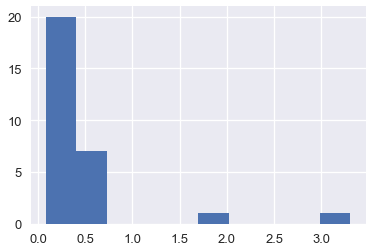

In [14]:
# show the average validities for the right eye for each participant, optionally run the histogram command

total_data.groupby(['ParticipantName']).ValidityRight.mean().sort_values(ascending=False).hist()
right_validity = total_data.groupby(['ParticipantName']).ValidityRight.mean().sort_values(ascending=False)
right_validity

ParticipantName
P19    0.135918
P15    0.056686
P06    0.039641
P13    0.024731
P18    0.021938
P25    0.017117
P26    0.016191
P03    0.013918
P16    0.005785
P17    0.003247
P07    0.003201
P11    0.001847
P14   -0.000210
P28   -0.002782
P24   -0.003279
P22   -0.003431
P02   -0.003656
P05   -0.005356
P08   -0.006047
P29   -0.008957
P10   -0.009325
P21   -0.009490
P01   -0.010741
P09   -0.019812
P04   -0.027244
P20   -0.033588
P27   -0.037986
P12   -0.044297
P23   -0.080252
dtype: float64

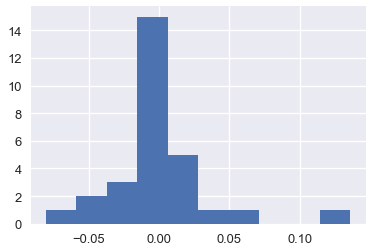

In [15]:
# This shows how much better the validity for left eye was than for the right eye. There's only a big difference
# for participant 23 and participant 15, it may be better to only use their right eye and left eye data, respectively.

diff_validity = left_validity - right_validity

diff_validity.hist()
diff_validity.sort_values(ascending=False)

In [16]:
# display the start and end for each word for each participant
"""
If the difference in time for a media between the start and end is very short, that means it was skipped by and we 
should delete it, however we will need to double check the result of those deletions with the recording sheet to make 
sure that we didn't delete times when the participant solved the anagram very quickly. Note that RecordingTimestamp 
is measured in milliseconds and starts at 0 for each participants and ends at however long the recording was for 
that participant. Divide by 60,000 to convert to minutes.
Note that the ParticipantName and MediaName columns are in some kind of alphabetical order here.
"""
# There's a bug here, which is that the '123456' and the 'black_break_image' show up more than once, so the time 
# between the min and max for them will be extremely large


participant_media_timestamp = total_data.groupby(['ParticipantName', 'MediaName']).RecordingTimestamp

In [17]:
grouped_timestamp = total_data.groupby(['ParticipantName', 'MediaName'])

In [18]:
# drop the rows when less than 2 seconds are spent on the MediaName
total_data = grouped_timestamp.filter(lambda x: x.RecordingTimestamp.max() - x.RecordingTimestamp.min() > 2000)

18.119483333333335

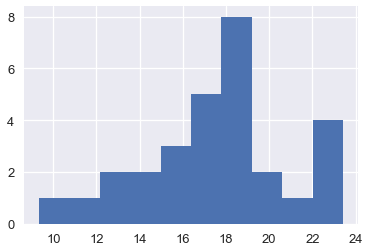

In [19]:
"""
Find the total recording time for each participant (in minutes). The median is 18 minutes. The total time of the 
experiment was 30 minutes but for some it took a longer or shorter amount of time to do the calibration/read the 
prompt. Also near the end we promised to let participants out after 25 minutes to incentivize them to come, plus it 
seemed as though 30 minutes was too long and the quality of data would go down.
"""

# (divide by 60000 to convert from milliseconds to minutes)
total_recording_time = total_data.groupby(['ParticipantName']).RecordingTimestamp.max().map(lambda x: x / 60000)

total_recording_time.hist()
total_recording_time.median()

In [20]:
"""
The coordinates for the five and six letter words are provided. They're listed as [x, y] where x and and y are both
measured from the top left corner of the screen. They coordinates are provided in clockwise direction from left middle
such that they align with the entries in the 'MediaName' column. For example, if the MediaName is 'anagram_PWROE.tiff'
then the coordinate for the letter P is [32, 507], the coordinate for W is [451, 44], R is [1131, 222], etc.
The same thing for the six letter words. Thus, some simple code can be written to convert from MediaName to 
the location of the coordinates for each letter in the word.
In fact, we should probably convert the MediaName to just be anagram, so 'anagram_PWROE.tiff' is written as 'PWROE'.
"""
five_letter_coordinates = [[32, 507], [451, 44], [1131, 222], [1132, 793], [450, 971]]
six_letter_coordinates = [[35, 509], [335, 87], [943, 87], [1245, 509], [944, 928], [334, 928]]

# Note that these are the distances between the coordinates, the code for finding them is shown below, just some 
# pythagorean theorem
five_letter_distances = [624.4, 702.9, 571.0, 704.8, 624.5]
six_letter_distances = [517.8, 608.0, 518.9, 515.9, 610.0, 514.7]

# The letters are not equidistant from each other, the way the MATLAB code was written for making the stimuli was so 
# that the angles between the letters would be equal

# Half the distance between adjacent letters tell us the maximum possible radius we can use to call a 'hit'
# on each letter. The minimum half distance for the five-letter-words is 285 and for the six-letter-words is 257.
half_five_letter_distances = [312.2, 351.5, 285.5, 352.4, 312.3]
half_six_letter_distances = [258.9, 304.0, 259.5, 258.0, 305.0, 257.4]

# We might even want to use half of those minimums, which for the five-letter-words is 143 and for the six-letter-
# words is 129. Therefore, any distance less than 143 is a hit for the five-letter-words and any distance less than
# 129 is a hit for the six-letter-words


# total_data.MediaName.unique()
# total_data.ParticipantName.unique()

In [21]:
ROUND = 6


def measure_distances(coordinate_list, round_number=ROUND):
    coordinate_list_copy = []
    for element in coordinate_list:
        coordinate_list_copy.append(element)
    
    coordinate_list_copy.append(coordinate_list_copy[0])
    distances = []
    for i in range(len(coordinate_list_copy) - 1):
        x_d = coordinate_list_copy[i + 1][0] - coordinate_list_copy[i][0]
        y_d = coordinate_list_copy[i + 1][1] - coordinate_list_copy[i][1]

        d = ((x_d ** 2) + (y_d ** 2)) ** 0.5
        distances.append(round(d, round_number))
    return distances


five_letter_distances = measure_distances(five_letter_coordinates)
six_letter_distances = measure_distances(six_letter_coordinates)

half_five_letter_distances = [round(value / 2, 6) for value in five_letter_distances]
half_six_letter_distances = [round(value / 2, 6) for value in six_letter_distances]


print(min(half_five_letter_distances) / 2)
print(min(half_six_letter_distances) / 2)

142.750219
128.686149


In [22]:
# Here you can see that P13 and P14 had the same stimuli, unfortunately.

# total_data.groupby('ParticipantName').MediaName.unique()

In [23]:
# Drop all entries from the participants whose eyes could not be identified well by the eye trackier (particpants 16
# and 19)

total_data = total_data[(total_data.ParticipantName != 'P19') & (total_data.ParticipantName != 'P16')]

In [24]:
# Now we can see that 'P19' and 'P16' are dropped
# total_data.ParticipantName.unique()

In [25]:
# total_data

In [26]:
# Set the five_d_1 column to be length of a media name: '4' if the MediaName is none, '5' if the MediaName is 12345 or
# a five letter word, '6' if the MediaName is 123456 or a six letter word, and '17' if the MediaName is 
# 'black_break_image'. This way, we avoid having to use apply(), which I've tried using and it is way way too slow.
total_data['five_d_1'] = total_data.MediaName.str.len().astype(str) + '<' + total_data.gen_gazeX.astype(str) + '<' + total_data.gen_gazeY.astype(str)

# copy the string in five_d_1 to all the other five_d's 
total_data['five_d_2'] = total_data['five_d_3'] = total_data['five_d_4'] = total_data['five_d_5'] = total_data.five_d_1


In [27]:
# do the same for six_d_1 

total_data['six_d_1'] = total_data.MediaName.str.len().astype(str) + '<' + total_data.gen_gazeX.astype(str) + '<' + total_data.gen_gazeY.astype(str)
total_data['six_d_2'] = total_data['six_d_3'] = total_data['six_d_4'] = total_data['six_d_5'] = total_data['six_d_6'] = total_data.six_d_1


In [28]:
five_letter_coordinates = [[32, 507], [451, 44], [1131, 222], [1132, 793], [450, 971]]

distance_number = 1

def get_distance_5(entry):
    entry = entry.split('<')
    # if the MediaName length is 4, 6, or 17, return NaN
    # Yes I know this is badly written but when I used 'or' the whole notebook crashed and that happened a few times 
    # so I'm playing it safe. 
    if entry[0] == '4':
        return float('nan')
    elif entry[0] == '6':
        return float('nan')
    elif entry[0] == '17':
        return float('nan')
    
    # Else, return the distance betwen the coordinate of the gaze and the letter in question
    else:
        x1 = float(entry[1])
        y1 = float(entry[2])
        
        x0 = five_letter_coordinates[distance_number - 1][0]
        y0 = five_letter_coordinates[distance_number - 1][1]
        
        xd_sq = (x1 - x0) ** 2
        yd_sq = (y1 - y0) ** 2
        
        d = (xd_sq + yd_sq) ** 0.5
        
        return d


In [29]:
distance_number = 1
total_data.five_d_1 = total_data.five_d_1.map(get_distance_5)

distance_number = 2
total_data.five_d_2 = total_data.five_d_2.map(get_distance_5)

distance_number = 3
total_data.five_d_3 = total_data.five_d_3.map(get_distance_5)

distance_number = 4
total_data.five_d_4 = total_data.five_d_4.map(get_distance_5)

distance_number = 5
total_data.five_d_5 = total_data.five_d_5.map(get_distance_5)

In [30]:
six_letter_coordinates = [[35, 509], [335, 87], [943, 87], [1245, 509], [944, 928], [334, 928]]

distance_number = 1

def get_distance_6(entry):
    entry = entry.split('<')
    # if the MediaName length is 4, 5, or 17, return NaN
    if entry[0] == '4':
        return float('nan')
    elif entry[0] == '5':
        return float('nan')
    elif entry[0] == '17':
        return float('nan')
    
    # Else, return the distance betwen the coordinate of the gaze and the letter in question
    else:
        x1 = float(entry[1])
        y1 = float(entry[2])
        
        x0 = six_letter_coordinates[distance_number - 1][0]
        y0 = six_letter_coordinates[distance_number - 1][1]
        
        xd_sq = (x1 - x0) ** 2
        yd_sq = (y1 - y0) ** 2
        
        d = (xd_sq + yd_sq) ** 0.5
        
        return d


In [31]:
distance_number = 1
total_data.six_d_1 = total_data.six_d_1.map(get_distance_6)

distance_number = 2
total_data.six_d_2 = total_data.six_d_2.map(get_distance_6)

distance_number = 3
total_data.six_d_3 = total_data.six_d_3.map(get_distance_6)

distance_number = 4
total_data.six_d_4 = total_data.six_d_4.map(get_distance_6)

distance_number = 5
total_data.six_d_5 = total_data.six_d_5.map(get_distance_6)

distance_number = 6
total_data.six_d_6 = total_data.six_d_6.map(get_distance_6)

In [32]:
# Now make the hits

In [33]:
hit_five_num = total_data.MediaName + '<' + total_data.five_d_1.astype(str) + '<' + total_data.five_d_2.astype(str) + '<' + total_data.five_d_3.astype(str) + '<' + total_data.five_d_4.astype(str) + '<' + total_data.five_d_5.astype(str)

In [34]:
hit_six_num = total_data.MediaName + '<' + total_data.six_d_1.astype(str) + '<' + total_data.six_d_2.astype(str) + '<' + total_data.six_d_3.astype(str) + '<' + total_data.six_d_4.astype(str) + '<' + total_data.six_d_5.astype(str) + '<' + total_data.six_d_6.astype(str)

In [35]:
hit_word_length = 5

def convert_hit(hit_entry):
    if hit_word_length == 5:
        min_hit_distance = 143
    elif hit_word_length == 6:
        min_hit_distance = 129
    hit_entry_list = hit_entry.split('<')
    if len(hit_entry_list[0]) != hit_word_length:
        return float('nan')
    else: 
        hit_entry_list_nums_only = hit_entry_list[1:]
        hit_entry_list_nums_only_float = [float(value) for value in hit_entry_list_nums_only]
        min_distance = min(hit_entry_list_nums_only_float)
        min_number_clockwise = hit_entry_list_nums_only_float.index(min_distance) + 1
        if min_distance <= min_hit_distance:
            # if we want the distance then run this instead:
            # return min_distance
            return min_number_clockwise
        else:
            # return float('nan')
            return 0

In [36]:
hit_word_length = 5
total_data['five_hit_num_clock'] = hit_five_num.map(convert_hit)

In [37]:
hit_word_length = 6
total_data['six_hit_num_clock'] = hit_six_num.map(convert_hit)

## Sequence

In [38]:
# Add the minimum timestamp for each participant - media
total_data['time_stamp_min'] = total_data.groupby(['ParticipantName', 'MediaName']).RecordingTimestamp.transform('min')

In [39]:
# Run the cell with five_hit_num_clock and six_hit_num_clock

five_sequence = total_data.filter(['ParticipantName', 'MediaName', 'five_hit_num_clock', 'RecordingTimestamp', \
                                   'time_stamp_min'])

five_sequence['ParticipantMedia'] = five_sequence.ParticipantName + '_' + five_sequence.MediaName
five_sequence['MediaTimestamp'] = five_sequence.RecordingTimestamp - five_sequence.time_stamp_min
five_sequence = five_sequence.loc[five_sequence.MediaName != 'none']
five_sequence = five_sequence.drop(['ParticipantName', 'MediaName', 'RecordingTimestamp', 'time_stamp_min'], axis=1)
five_sequence = five_sequence.pivot_table(values='five_hit_num_clock', index='MediaTimestamp', \
                                          columns='ParticipantMedia')

# You can see what this looks like by running the below:



In [40]:
sequence_time_data = five_sequence

In [41]:
five_sequence1 = five_sequence.fillna(0)

# Make the columns of five_sequence into a list
five_name_sequence = []
for column in five_sequence1:
    seq_5_to_add = [column, five_sequence1[column].tolist()]
    five_name_sequence.append(seq_5_to_add)
    
# Go through the list and delete 0's which are the previous NaN's
for i in range(len(five_name_sequence)):
    media_name = five_name_sequence[i][0]
    sequence = five_name_sequence[i][1]
    
    # drop 0's
    sequence_new0 = []
    for j in range(len(sequence)):
        if sequence[j] != 0:
            sequence_new0.append(sequence[j])
    # drop repeats
    sequence_new1 = []
    for k in range(len(sequence_new0) - 1):
        if sequence_new0[k] != sequence_new0[k + 1]:
            sequence_new1.append(sequence_new0[k])
    five_name_sequence[i] = [media_name, sequence_new1]
    
# turn into dictionary to make into a dataframe
five_name_sequence_dict = {}
for row in five_name_sequence:
    five_name_sequence_dict[row[0]] = row[1]
    
    
# Make into a dataframe. 
# Make sure there are two different names for the five and six letter data: I use sequence_data0 for five letter
# and sequence_data1 for six letter. 

sequence_data0 = pd.DataFrame({ key:pd.Series(value) for key, value in five_name_sequence_dict.items() })

In [42]:
# Run the next three cells (including this one) with six_hit_num_clock and five_hit_num_clock. 

# Ignore the name 'five_sequence' everywhere, it would just take too long to rename to six sequence
five_sequence = total_data.filter(['ParticipantName', 'MediaName', 'six_hit_num_clock', 'RecordingTimestamp', \
                                   'time_stamp_min'])
five_sequence['ParticipantMedia'] = five_sequence.ParticipantName + '_' + five_sequence.MediaName
five_sequence['MediaTimestamp'] = five_sequence.RecordingTimestamp - five_sequence.time_stamp_min
five_sequence = five_sequence.loc[five_sequence.MediaName != 'none']
five_sequence = five_sequence.drop(['ParticipantName', 'MediaName', 'RecordingTimestamp', 'time_stamp_min'], axis=1)
five_sequence = five_sequence.pivot_table(values='six_hit_num_clock', index='MediaTimestamp', \
                                          columns='ParticipantMedia')

# You can see what this looks like by running the below:
# five_sequence


In [43]:
sequence_time_data = five_sequence.join(sequence_time_data)

In [44]:
five_sequence1 = five_sequence.fillna(0)

# Make the columns of five_sequence into a list
five_name_sequence = []
for column in five_sequence1:
    seq_5_to_add = [column, five_sequence1[column].tolist()]
    five_name_sequence.append(seq_5_to_add)
    
# Go through the list and delete 0's which are the previous NaN's
for i in range(len(five_name_sequence)):
    media_name = five_name_sequence[i][0]
    sequence = five_name_sequence[i][1]
    
    # drop 0's
    sequence_new0 = []
    for j in range(len(sequence)):
        if sequence[j] != 0:
            sequence_new0.append(sequence[j])
    # drop repeats
    sequence_new1 = []
    for k in range(len(sequence_new0) - 1):
        if sequence_new0[k] != sequence_new0[k + 1]:
            sequence_new1.append(sequence_new0[k])
    five_name_sequence[i] = [media_name, sequence_new1]
    
# turn into dictionary to make into a dataframe
five_name_sequence_dict = {}
for row in five_name_sequence:
    five_name_sequence_dict[row[0]] = row[1]
    
    
# Make into a dataframe. 
# Make sure there are two different names for the five and six letter data: I use sequence_data0 for five letter
# and sequence_data1 for six letter. 

sequence_data1 = pd.DataFrame({ key:pd.Series(value) for key, value in five_name_sequence_dict.items() })

In [45]:
# Join the two dataframes, make sure to join the six on the left and five on the right or you'll lose data
sequence_data = sequence_data1.join(sequence_data0)

In [46]:
# The 123456 MediaName's have a bug in them because they show up twice, we need to rename the second one for 
# every participant. We'll get to this later. It's the same bug as mentioned before. 
sequence_data

,P01_123456,P01_ARDIEM,P01_IUJONR,P01_KUMEPA,P01_LEADFW,P01_MDTOSE,P01_PNEUTA,P01_RYEABT,P01_SCODLE,P02_123456,P02_AFDWLE,P02_CEOLDS,P02_IAMEDR,P02_NOJUIR,P03_123456,P03_CSOELD,P03_JIUORN,P03_RAIMED,P03_WFEADL,P03_YRBATE,P04_123456,P04_ATEYRB,P04_DIEMAR,P04_ELCSDO,P04_INOJRU,...,P25_12345,P25_CROUT,P25_HLACK,P25_RWBNO,P25_WOEPR,P26_12345,P26_KACLH,P26_RWOBN,P26_TUCRO,P26_WEORP,P27_12345,P27_ALHKC,P27_PEORW,P27_ROUTC,P27_WRNBO,P28_12345,P28_AKCLH,P28_BNORW,P28_OEPRW,P28_UROTC,P29_12345,P29_HLCKA,P29_PEOWR,P29_RCTUO,P29_RNOBW
0,4.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,2.0,2.0
1,2.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,6.0,3.0,3.0,1.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,2.0,3.0,3.0,2.0,1.0,...,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0,5.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,4.0,2.0,3.0,3.0,3.0
2,1.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,5.0,4.0,5.0,1.0,5.0,4.0,2.0,4.0,4.0,3.0,6.0,4.0,4.0,1.0,6.0,...,4.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,4.0,4.0,5.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,1.0,2.0,3.0,2.0,4.0,1.0
3,6.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,2.0,6.0,5.0,6.0,5.0,6.0,5.0,3.0,3.0,5.0,4.0,5.0,1.0,3.0,6.0,5.0,...,5.0,5.0,5.0,5.0,1.0,3.0,4.0,3.0,5.0,5.0,1.0,4.0,3.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,5.0,2.0
4,5.0,1.0,6.0,6.0,5.0,6.0,6.0,6.0,6.0,4.0,5.0,2.0,2.0,4.0,2.0,6.0,4.0,4.0,6.0,3.0,4.0,6.0,2.0,2.0,4.0,...,1.0,1.0,1.0,1.0,5.0,5.0,2.0,4.0,1.0,2.0,5.0,5.0,2.0,5.0,5.0,2.0,1.0,4.0,1.0,3.0,4.0,5.0,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
pd.set_option('display.max_rows', 205)

combined_j = pd.read_csv('combined_data_j.csv')

In [48]:
solved_list = list()
for row in combined_j['1=Solved']:
    solved_list.append(row)

In [49]:
# This relates the letter sequence to the point of time during the participant-word
# sequence_time_data

In [50]:
# get the sequence list (middle left = 1, increases going clockwise)
sequence_list_float = list()
for column in sequence_data:
    sequence_list_float.append([str(column), list(sequence_data[column])])

sequence_list = list()
for row in sequence_list_float:
    sequence_list_row = [row[0]]
    sequence = list()
    for seq_num in row[1]:
        if seq_num != seq_num:
            break
        else:
            sequence.append(int(seq_num))
    sequence_list_row.append(sequence)
    sequence_list.append(sequence_list_row)
    
# drop calibrations, we can do them later 
sequence_list = [row for row in sequence_list if row[0][4:] != '123456' and row[0][4:] != '12345']

In [51]:
# Add solved or not to sequence_list
for i in range(len(sequence_list)):
    sequence_list[i].append(solved_list[i])

In [52]:
direction5 = list()
direction6 = list()
# sequence list direction is the direction of movement in the sequence length 
sequence_list_direction = list()
for row in sequence_list:
    sequence_direction = list()
    length = len(row[1]) - 1
    for i in range(length):
        v = row[1][i + 1] - row[1][i]
        # if six letter word
        if len(row[0]) == 10:
            if abs(v) > 3:
                v = int((6 - abs(v)) * -1 * (v / abs(v)))
            elif v == -3:
                v = 3
            direction6.append(v)
            sequence_direction.append(v)
        # if five letter word
        elif len(row[0]) == 9:
            if abs(v) > 2:
                v = int((5 - abs(v)) * -1 * (v / abs(v)))
            direction5.append(v)
            sequence_direction.append(v)
        
    sequence_list_direction.append([row[0], sequence_direction, row[2]])


In [53]:
# get the letter sequence
sequence_list_letter = list()
for row in sequence_list:
    sequence_list_letter_row = [row[0]]
    letters = row[0][4:]
    sequence = [value for value in row[1]]
    for i, letter in enumerate(letters):
        for j in range(len(sequence)):
            if sequence[j] == i + 1:
                sequence[j] = letter
    sequence_list_letter_row.append(sequence)
    sequence_list_letter_row.append(row[2])
    sequence_list_letter.append(sequence_list_letter_row)

In [54]:
total_word_list = ['FLAWED', 'CLOSED', 'ADMIRE', 'JUNIOR', 'BETRAY', 'PEANUT', 'MODEST', \
             'MAKEUP', 'CHALK', 'POWER', 'BROWN', 'COURT']

def check_letters_word_list(letters, word_list):
    for word in word_list:
        if check_letters_one_word(letters, word) is True:
            return word 

def check_letters_one_word(letters, word):
    is_word = True
    for letter in letters:
        if letter not in word:
            is_word = False
    return is_word

In [55]:
# get the letter sequence as numbers representing the order of letters in the word 
sequence_list_letter_order = list()
for row in sequence_list_letter:
    sequence_list_letter_order_row = [row[0]]
    letters = row[0][4:]
    word = check_letters_word_list(letters, total_word_list)
    sequence = [value for value in row[1]]
    for i, letter in enumerate(word):
        for j in range(len(sequence)):
            if sequence[j] == letter:
                sequence[j] = i + 1
    sequence_list_letter_order_row.append(sequence)
    sequence_list_letter_order.append(sequence_list_letter_order_row)

In [56]:
order_direction = list()
order_direction5 = list()
order_direction6 = list()
for row in sequence_list_letter_order:
    order_direction_one = list()
    length = len(row[1]) - 1
    for i in range(length):
        v = row[1][i + 1] - row[1][i]
        order_direction_one.append(v)
        # if six letter word
        if len(row[0]) == 10:
            order_direction6.append(v)
        # if five letter word
        elif len(row[0]) == 9:
            order_direction5.append(v)
    order_direction.append(order_direction_one)


## Statistics




Make a bunch of parallel np arrays (total length of 202, unless we cut more out for some reason). Did people have a bias towards some two or three letter combination, what would those have been? Presumeably that can't be accounted for by the position of the letters on the screen because they were randomized (albeit with a low chance of in-sequence letters showing up next to each other). Do people tend to try to spell out words within the shuffled word? How does the proportion of in-sequence letters change over time? (We'll probably have to trim down the very short ones. I'm thinking of making ten deciles so to speak, so we'll need letter sequences at least 10 long. 

### Post-meeting notes

Use a 1 for the first bigram in the word, that might be more predictive. 
First check for a simple correlation between the post-experiment survey responses and whether or not the word was solved. 






In [94]:
# N is the number of rows for every single numpy array in the next cell
N = len(Y)

In [95]:
X_words = [int(value) for value in X_words]

In [192]:
X_wordlengths

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [ ]:
# Going list of parallel numpy arrays
# 'Y's 
Y  # 1 or 0 for correct vs incorrect

# X's 

# each entry is from an anagram scenario

# singular entry rows
X_words  # number identifier of the word (corresponds to index of total_word_list)
X_wordlengths  # length of the word (either 5 or 6)
X_par  # participant ID number (1 through 29)
X_seqlengths # the length of the letter sequence data  

X_loc_all
X_loc_first
X_loc_second
X_loc_third
X_loc_fourth

# array entry rows
# (each entry represents an anagram scenario)
X_order # number representing the number letter in the word
X_ones  # 1 for each in-sequence (in the word) letter to letter read, else 0. (sub L - 1)

X_ones_first # (sub L - 1)
X_ones_second # (sub L - 1)
X_ones_third # (sub L - 1)
X_ones_fourth # (sub L - 1)

X_bigrams  # each bigram read by the participant. (sub L - 1)
X_trigrams # (sub L - 2)
X_fourgrams # (sub L - 3)
X_fivegrams # (sub L - 4)


# miscellaneous, gives the number of bigrams for each category
first_sizes
second_sizes
third_sizes
fourth_sizes
all_sizes

In [249]:
def location_from_ones(ones_array):
    locations = list()
    sizes = list()
    sizes_not = list()
    for i in range(N):            
        bigrams_len = len(ones_array[i])
        indices = list()
        for j in range(bigrams_len):
            if ones_array[i][j] == 1:
                indices.append(j + 1)
        sizes.append(len(indices))
        if len(indices) != 0:
            average_loc = sum(indices) / len(indices)
            percentage_loc = average_loc / bigrams_len
            locations.append(percentage_loc)
        else:
            locations.append(float('nan'))
    return np.array(locations), np.array(sizes)
    

def X_ones_n(bigram_number):
    X_ones_n_array = list() 
    for i in range(N):
        sub = list()
        for j in range(len(X_ones[i])):
            if X_ones[i][j] == 1 and X_order[i][j] == bigram_number:
                sub.append(1)
            else:
                sub.append(0)
        X_ones_n_array.append(np.array(sub))
    return np.array(X_ones_n_array)


def X_ones_last():
    X_ones_n_array = list() 
    for i in range(N):
        bigram_number = X_wordlengths[i] - 1
        sub = list()
        for j in range(len(X_ones[i])):
            if X_ones[i][j] == 1 and X_order[i][j] == bigram_number:
                sub.append(1)
            else:
                sub.append(0)
        X_ones_n_array.append(np.array(sub))
    return np.array(X_ones_n_array)


def give_info_locs(locs, sizes, title_denoter, sep=False):
    solved_locs = list()
    not_solved_locs = list()
    solved_sizes = list()
    not_solved_sizes = list()

    
    for i in range(len(locs)):
        if sizes[i] != 0:
            if Y[i] == 1:
                solved_locs.append(locs[i])
                solved_sizes.append(sizes[i])
            else:
                not_solved_locs.append(locs[i])
                not_solved_sizes.append(sizes[i])
                
    plt.title('Average location of ' + title_denoter + ' bigram of the solution word, by solved')
    plt.ylabel('average location')
    sns.swarmplot(['solved' if value == 1 else 'not solved' for value in Y], locs)
    plt.show()
    
    
    
    late = 0.7
    early = 1 - late
    
    late_solved_count = 0
    early_solved_count = 0
    for loc in solved_locs:
        if loc > late:
            late_solved_count += 1
        elif loc < early:
            early_solved_count += 1
    late_unsolved_count = 0
    early_unsolved_count = 0
    for loc in not_solved_locs:
        if loc > late:
            late_unsolved_count += 1
        elif loc < early:
            early_unsolved_count += 1
            
    late_solved_prop = late_solved_count / len(solved_locs)
    late_unsolved_prop = late_unsolved_count / len(not_solved_locs)
    early_solved_prop = early_solved_count / len(solved_locs)
    early_unsolved_prop = early_unsolved_count / len(not_solved_locs)
    
    late = round(late, 2)
    early = round(early, 2)
    plt.title('Proportion of average bigram locations past ' + \
              str(late) + ' and before ' + str(early) + ' by solved')
    
    plt.bar(['solved, past ' + str(late), 'not solved, past ' + str(late), \
             'solved, before ' + str(early), 'not solved, before ' + str(early)],
            [late_solved_prop, late_unsolved_prop, early_solved_prop, early_unsolved_prop])

    plt.show()
    

    sns.distplot(not_solved_locs, label='not solved', kde=True)
    sns.distplot(solved_locs, label='solved', kde=True)
    plt.title('Probability densities of average location of reading ' + title_denoter + \
              ' bigram of the solution word\n\
    for each anagram-scenario, by whether the anagram was solved or not solved.\n\
    Location given by percentage of the way through solving the anagram.\n Sample sizes: ' + \
              str(len(solved_locs)) + ' solved. ' + str(len(not_solved_locs)) + \
              ' not solved.')
    plt.ylabel('probability density')
    plt.xlabel('percentage through working on anagram')
    plt.legend()
    plt.show()
    
    sns.distplot(not_solved_locs, label='not solved', kde=False, norm_hist=False)
    sns.distplot(solved_locs, label='solved', kde=False, norm_hist=False)
    plt.title('Frequencies of average location of reading ' + title_denoter + ' bigram of' +\
    ' the solution word\n\
    for each anagram-scenario, by whether the anagram was solved or not solved.\n\
    Location given by percentage of the way through solving the anagram.\n Sample sizes: ' + \
              str(len(solved_locs)) + ' solved. ' + str(len(not_solved_locs)) + \
              ' not solved.')
    plt.ylabel('frequency')
    plt.xlabel('percentage through working on anagram')
    plt.legend()
    plt.show()
    
    print('FOR NOT SOLVED')
    avg_median_stdev_skewness(not_solved_locs)
    print()
    print('Average number of ones:', sum(not_solved_sizes) / len(not_solved_sizes))
    print()
    print('FOR SOLVED')
    avg_median_stdev_skewness(solved_locs)
    print()
    print('Average number of ones:', sum(solved_sizes) / len(solved_sizes))


In [235]:
X_ones_first = X_ones_n(1)
X_ones_second = X_ones_n(2)
X_ones_third = X_ones_n(3)
X_ones_fourth = X_ones_n(4)
X_ones_final = X_ones_last()
X_loc_first, first_sizes = location_from_ones(X_ones_first)
X_loc_second, second_sizes = location_from_ones(X_ones_second)
X_loc_third, third_sizes = location_from_ones(X_ones_third)
X_loc_fourth, fourth_sizes = location_from_ones(X_ones_fourth)
X_loc_final, final_sizes = location_from_ones(X_ones_final)
X_loc_all, all_sizes = location_from_ones(X_ones)


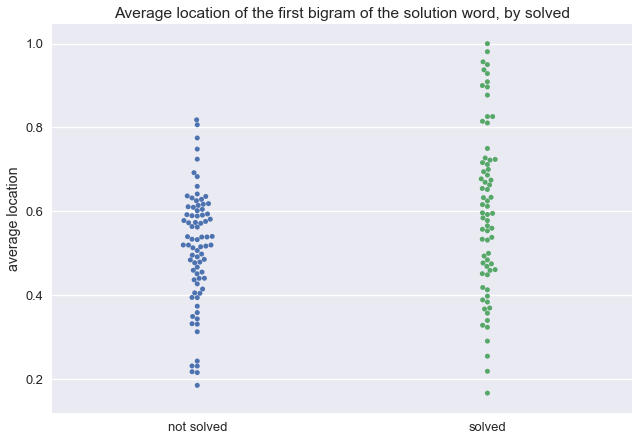

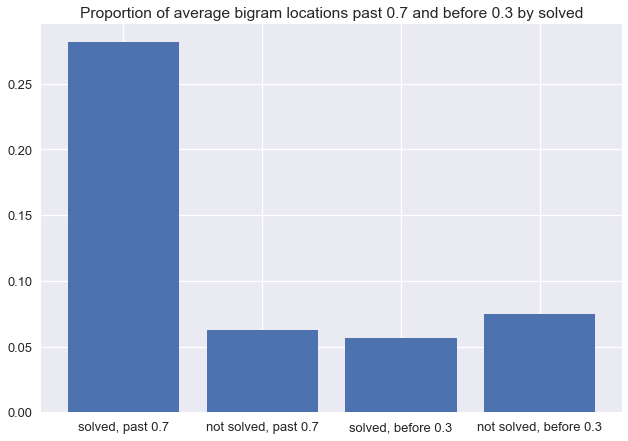

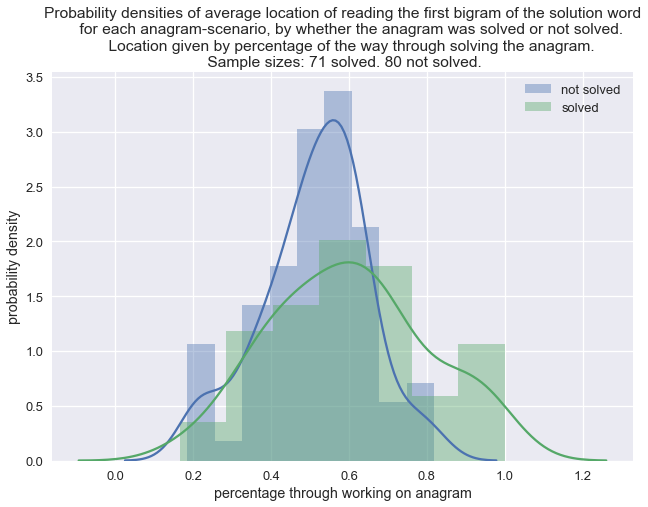

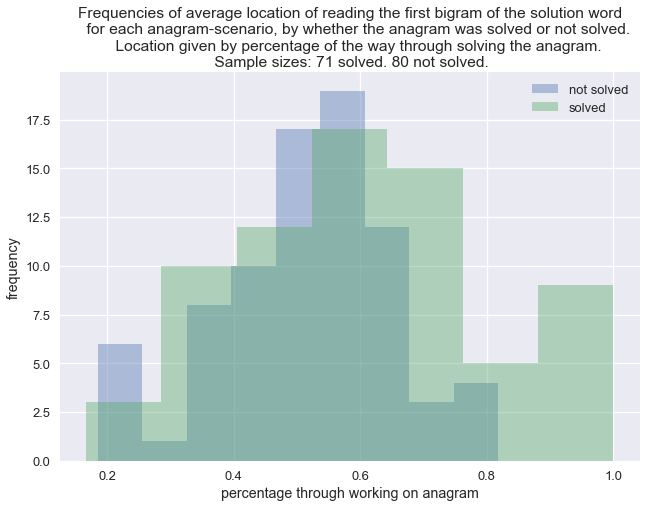

FOR NOT SOLVED
Average 0.5135866235940603
Median 0.5262162420992147
St.Dev 0.13635711777453252
Skewness -0.3503290340016885

Average number of ones: 7.1

FOR SOLVED
Average 0.6011514480807448
Median 0.5952380952380952
St.Dev 0.19962668686504115
Skewness 0.118584604768657

Average number of ones: 3.408450704225352


In [259]:
give_info_locs(X_loc_first, first_sizes, 'the first')

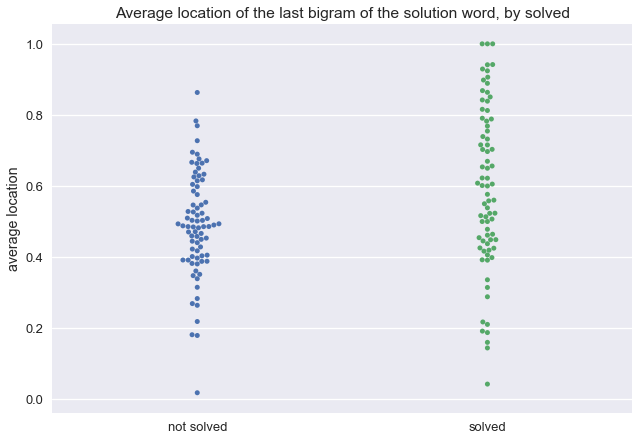

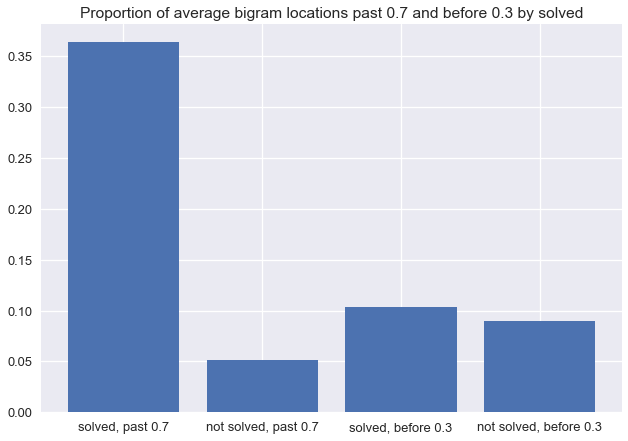

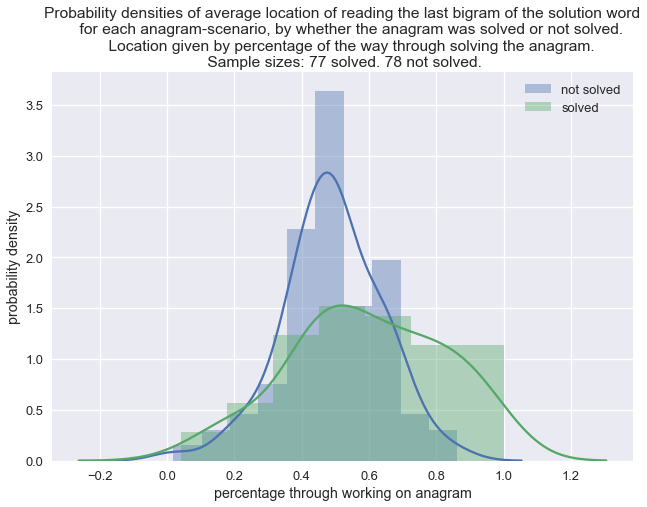

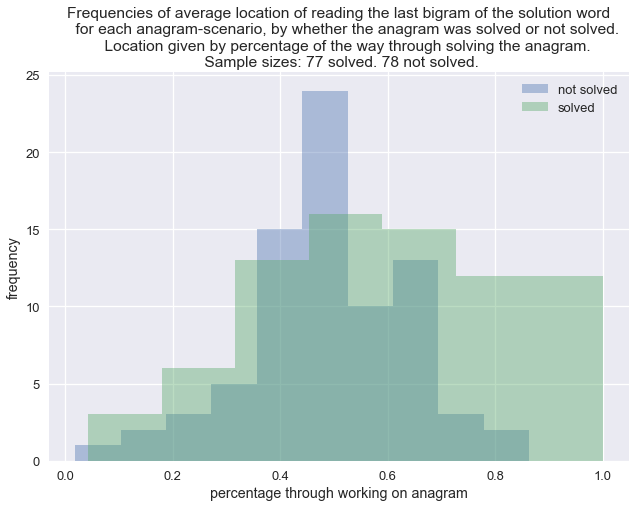

FOR NOT SOLVED
Average 0.49078340563528927
Median 0.4869142415890906
St.Dev 0.14673207827902424
Skewness -0.2666247821882029

Average number of ones: 6.102564102564102

FOR SOLVED
Average 0.5957685356971487
Median 0.6
St.Dev 0.22916917160504366
Skewness -0.16788458181308602

Average number of ones: 2.9740259740259742


In [250]:
give_info_locs(X_loc_final, final_sizes, 'the last')

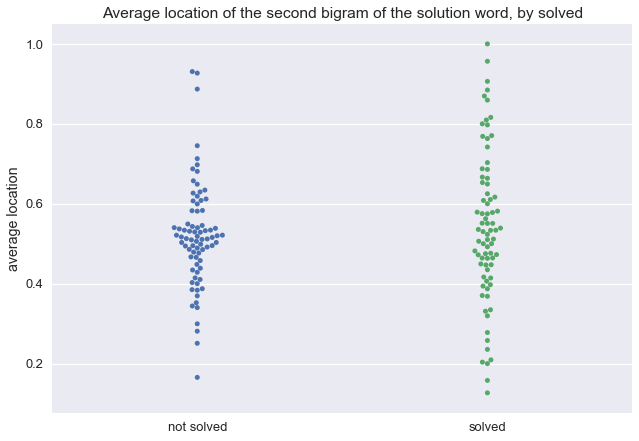

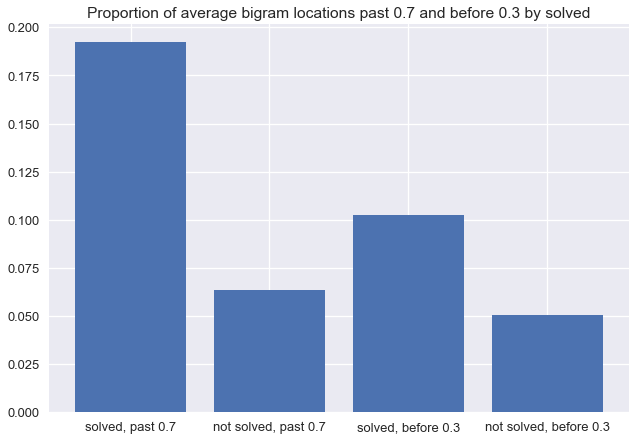

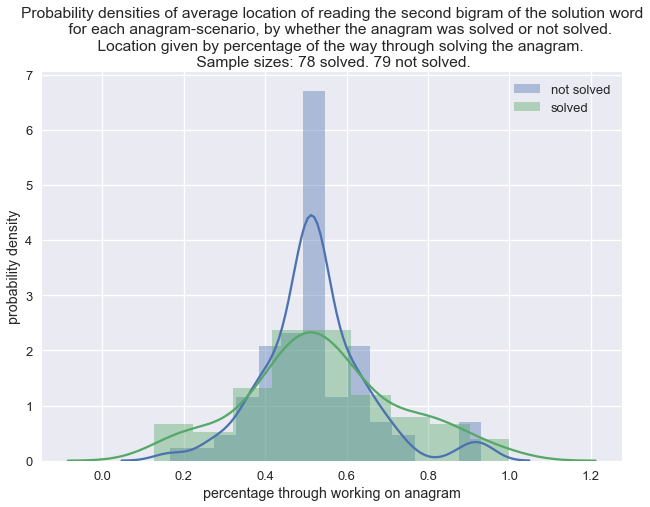

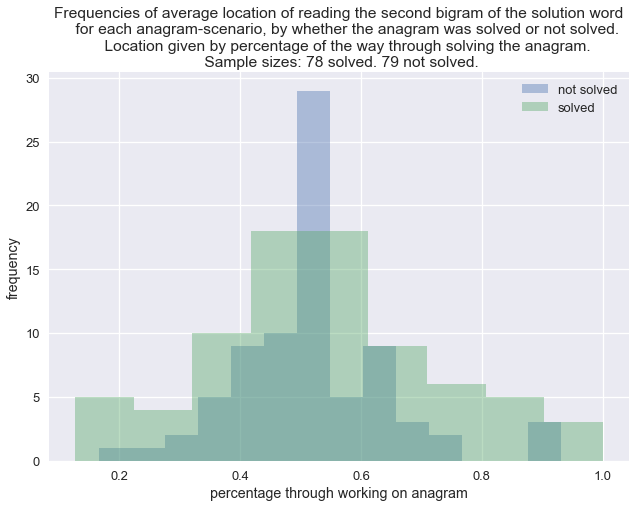

FOR NOT SOLVED
Average 0.5206203539452217
Median 0.5157232704402516
St.Dev 0.13115675313875994
Skewness 0.6039200658566486

Average number of ones: 7.8734177215189876

FOR SOLVED
Average 0.5408907117038654
Median 0.5318181818181817
St.Dev 0.18978136905238163
Skewness 0.1713267702300143

Average number of ones: 4.4743589743589745


In [252]:
give_info_locs(X_loc_second, second_sizes,'the second')

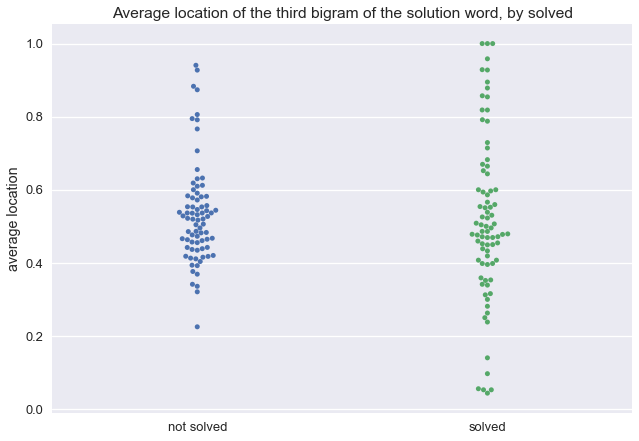

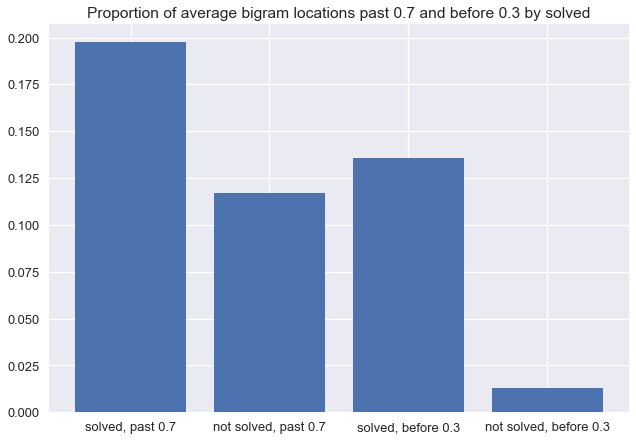

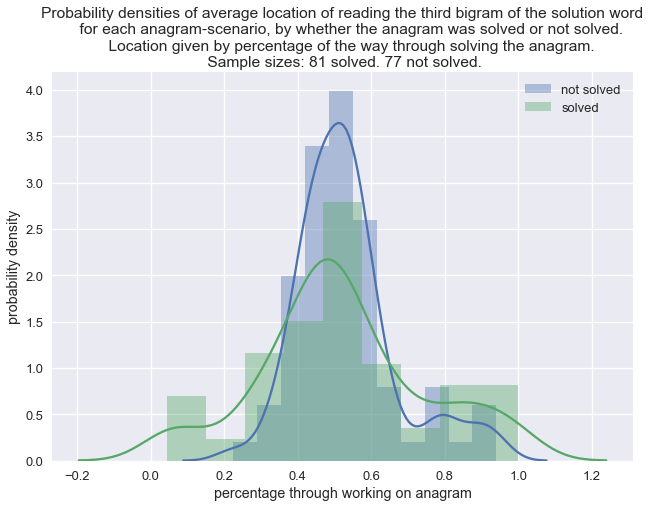

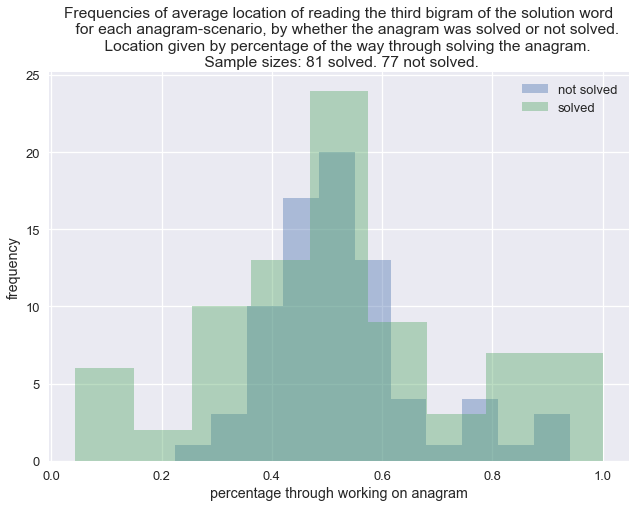

FOR NOT SOLVED
Average 0.5325652280841053
Median 0.5201773835920177
St.Dev 0.13735993400905833
Skewness 1.0550357910020152

Average number of ones: 7.935064935064935

FOR SOLVED
Average 0.5201929784491586
Median 0.4861111111111111
St.Dev 0.22777173618008137
Skewness 0.17842469454726254

Average number of ones: 4.049382716049383


In [253]:
give_info_locs(X_loc_third, third_sizes, 'the third')

In [258]:
# give_info_locs(X_loc_fourth, fourth_sizes, 'the fourth')

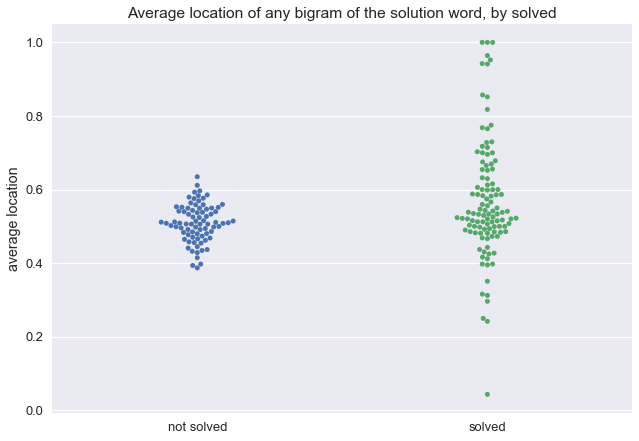

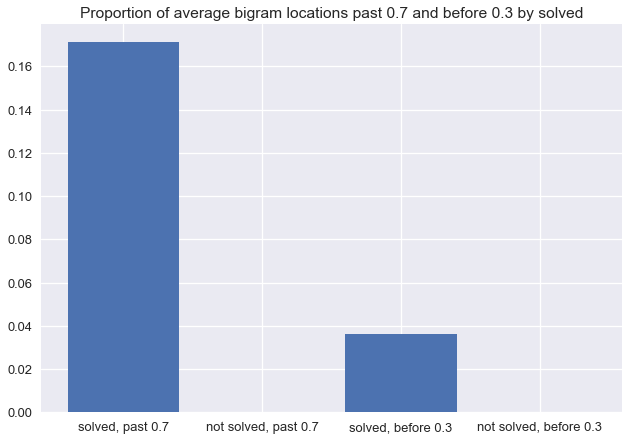

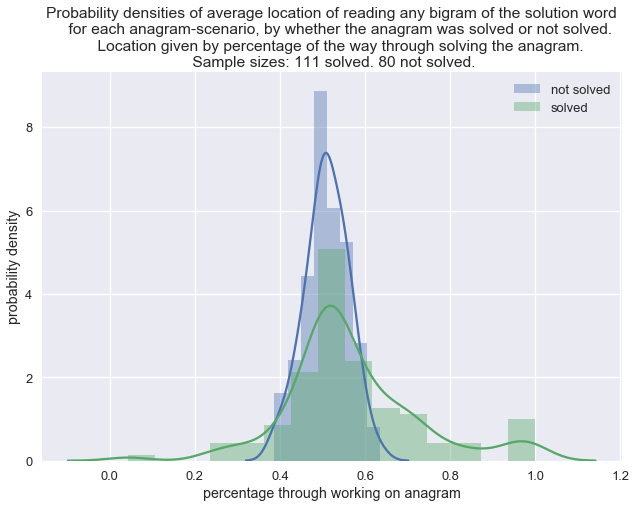

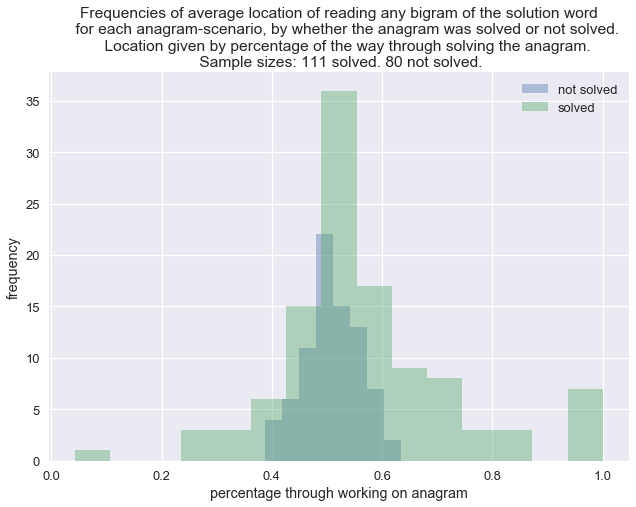

FOR NOT SOLVED
Average 0.5095806198697884
Median 0.508640351583016
St.Dev 0.05112945750899119
Skewness -0.15862351934881952

Average number of ones: 36.325

FOR SOLVED
Average 0.5692575901678627
Median 0.5337014470677837
St.Dev 0.1619648128523294
Skewness 0.5379791124827713

Average number of ones: 11.252252252252251


In [255]:
give_info_locs(X_loc_all, all_sizes, 'any')

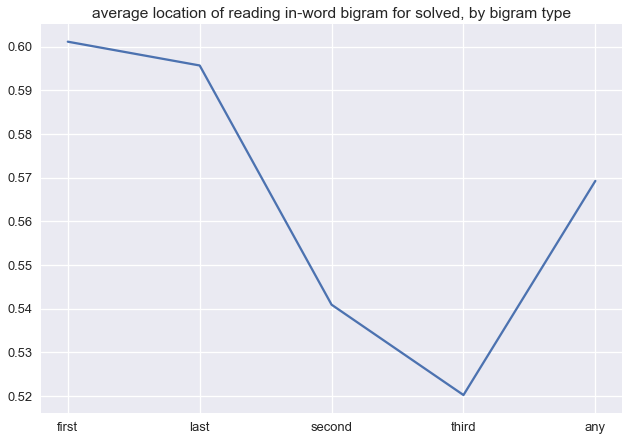

In [264]:
bigram_position = ['first', 'last', 'second', 'third', 'any']
avg_loc_solved = [0.60115, 0.5957, 0.54089, 0.52019, 0.569257]
plt.plot(bigram_position, avg_loc_solved)
plt.title('average location of reading in-word bigram for solved, by bigram type')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [257]:
def last_ones(ones_array, total_num_bigrams, last_num_bigrams):

    num_short = 0
    for value in X_seqlengths:
        if value < total_num_bigrams + 1:
            num_short += 1

    print('number short', num_short)

    X_last_ones = list()
    Y_last_ones = list()
    for i in range(len(Y)):
        if X_seqlengths[i] >= total_num_bigrams + 1:
            X_last_ones.append(ones_array[i][-last_num_bigrams:])
            Y_last_ones.append(Y[i])

    X_last_ones = np.array(X_last_ones)
    Y_last_ones = np.array(Y_last_ones)

    num = len(X_last_ones)
    Y_hot_last_ones = np.zeros((N, 2))

    for i in range(num):
        Y_hot_last_ones[i, Y_last_ones[i]] = 1  # if is a 0, it puts a 1 in the 0th column, etc. 
                                   # position for that row (1 hot encoding) - JM
    #     X_last_ones[i] = X_last_ones[i]-np.mean(X_last_ones[i]) # 0-mean
    #     X_last_ones[i] = X_last_ones[i]/np.sqrt(np.sum(X_last_ones[i]**2)) # makes each data point z-score/like - JM


    # Comparison with the simplistic idea.
    nPat, dim = np.shape(X_last_ones)
    avg_solutions = np.zeros((2,dim))
    # avg_images = np.zeros((2,8))
    counts = np.zeros(2)

    # The two for loops below get the average of the brightness values on the images for each digit.
    # I'm not sure why there's two cases (digits and images), when they're realy the same thing, just
    # in an 8 by 8 matrix versus a 64 length array. - JM
    for i in range(nPat):
        j = Y_last_ones[i]
        avg_solutions[j,:] = avg_solutions[j,:] + X_last_ones[i,:]
    #     avg_images[j,:,:] = avg_images[j,:,:]+np.reshape(X[i,:],(8,8))
        counts[j] = counts[j]+1

        # JM
    #     if i == 0:
    #         print(avg_digits[5,:])
    #         print(avg_images[5:,:])

    for j in range(2):
        avg_solutions[j,:] = avg_solutions[j,:]/counts[j]
    #     avg_images[j,:] = avg_images[j,:]/counts[j]

    print(counts)
    print(counts[1]/(counts[0] + counts[1]))

    # I suppose this answers my previous question, avg_images is for displaying the average brightness
    # values for each image in the imshows below. - JM
#     for j in range(10):
#         plt.subplot(2,5,j+1)
#         plt.imshow(avg_images[j,:,:])
#     plt.show()

    # Calculate distance from mean.
    Y_avg_pred = np.zeros(nPat)  # empty prediction array - JM
    for i in range(nPat):
        dist = np.zeros(2)  # empty array for putting sum of sq of errors btw the avg for each digit
                             # and the image (i) - JM
        for j in range(2):
            dist[j] = np.sum((X_last_ones[i,:]-avg_solutions[j,:])**2)  # for each coordinate on the image, get 
                                                           # the square of the difference from the
                                                           # average for each digit. - JM
            # JM testing
    #         if i == 0:
    #             if j == 9:
    #                 print('JM -', np.argmin(dist), dist, '- JM')  

        Y_avg_pred[i] = np.argmin(dist)  # Pick the one with the lowest sum of squared errors. - JM
    cm = confusion_matrix(Y_last_ones, Y_avg_pred) 
    print(cm)
    # Sum the number of correct predictions divided by the total number of predictions
    print('Performance = %3.5f'%(np.sum(np.diagonal(cm))/np.sum(cm))) 
    
    
    last_eight_bigrams = list(range(1,last_num_bigrams + 1))
    plt.title('proportion of in-word bigrams for last eight bigrams, by solved')
    plt.plot(last_eight_bigrams, avg_solutions[0], label='not solved')
    plt.plot(last_eight_bigrams, avg_solutions[1], label='solved')
    plt.legend()
    plt.show()


number short 30
[80. 92.]
0.5348837209302325
[[68 12]
 [59 33]]
Performance = 0.58721


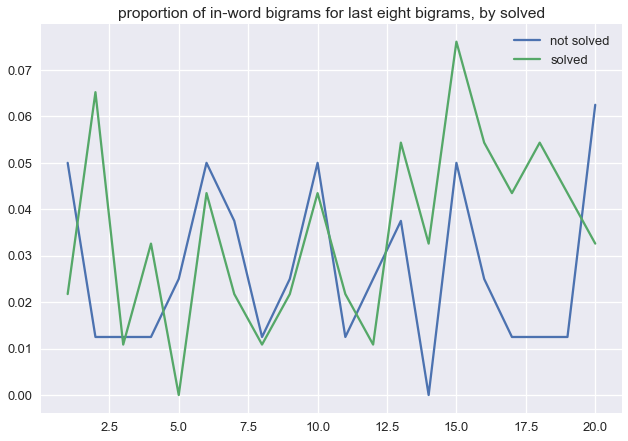

In [158]:
last_ones(X_ones_first, total_num_bigrams=20, last_num_bigrams=20)

number short 30
[80. 92.]
0.5348837209302325
[[63 17]
 [53 39]]
Performance = 0.59302


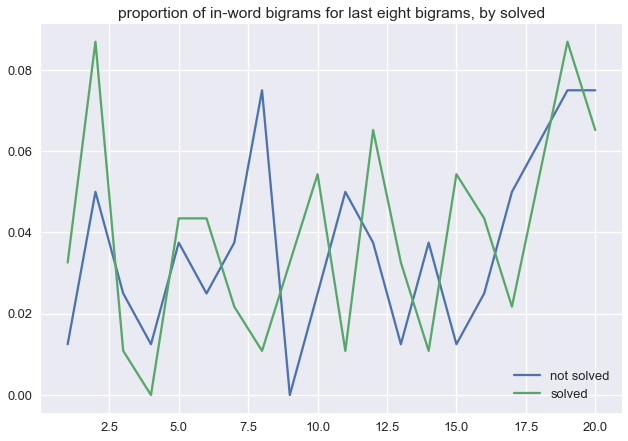

In [157]:
last_ones(X_ones_fourth, total_num_bigrams=20, last_num_bigrams=20)

number short 22
[ 80. 100.]
0.5555555555555556
[[50 30]
 [45 55]]
Performance = 0.58333


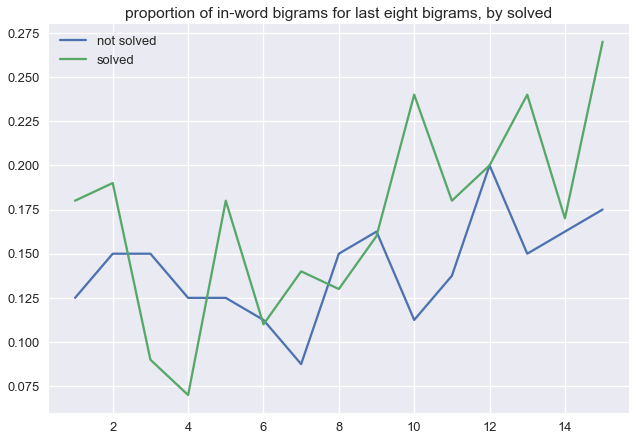

In [156]:
last_ones(X_ones, total_num_bigrams=15, last_num_bigrams=15)

In [ ]:
# sns.distplot([1,1,1,1,2,2,2,2,2,2], kde=False, norm_hist=False)

In [ ]:
# sns.swarmplot(['solved' if value == 1 else 'not solved' for value in Y], X_loc_all)

In [ ]:
# for i in range(N):
#     if Y[i] == 1 and (1 in X_ones_first[i]):
#         plt.title('participant ' + str(X_par[i]) + ', word ' + str(total_word_list[X_words[i]]) + ', ' + str(Y[i]))
#         plt.plot(X_ones_first[i])
# #     plt.title(str(Y[i]))
#         plt.show()

## Participant dataset

In [61]:
pars = pd.read_csv('participants.csv', index_col=0)

In [62]:
pars['prop_6_corr'] = pars.num_6_corr / pars.num_6_att
pars['prop_5_corr'] = pars.num_5_corr / pars.num_5_att

In [63]:
pars['method_len'] = pars.method.str.len()

In [64]:
pars.head()

,num_att,num_corr,num_5_corr,num_5_att,num_6_corr,num_6_att,method,fluency,vision,concentration,experience,elaborate,prop_6_corr,prop_5_corr,method_len
id,,,,,,,,,,,,,,,
1,8,5,NaN,NaN,5,8,I would look at all the letters and try to com...,Fluent,None,3,2,I was thinking about how long it was taking me...,0.625000,NaN,156
2,4,1,NaN,NaN,1,4,I did it randomly. I thought at first the lett...,Fluent,None,4,1,My focus gradually lessened as I began to lose...,0.250000,NaN,252
3,5,2,NaN,NaN,2,5,I first read the words around the circle a few...,Fluent,Contact Lenses,2,2,"I started out very concentrated, but as time w...",0.400000,NaN,190
4,6,0,NaN,NaN,0,6,I tried to see if there were any patterns,Fluent,Contact Lenses,5,1,I tried to stay as focused as possible. I trie...,0.000000,NaN,41
5,7,6,4.0,4.0,2,3,I looked at all of the letters in the order of...,Fluent,Glasses (Normal),5,3,"I had little distractions, other than the rese...",0.666667,1.0,186


In [65]:
pars.describe()

,num_att,num_corr,num_5_corr,num_5_att,num_6_corr,num_6_att,concentration,experience,prop_6_corr,prop_5_corr,method_len
count,27.000000,27.000000,23.000000,23.000000,27.000000,27.000000,27.000000,27.000000,26.000000,23.000000,27.000000
mean,7.518519,4.518519,3.391304,3.956522,1.629630,4.148148,4.074074,2.185185,0.357830,0.855072,218.407407
std,1.762218,2.137043,0.782718,0.208514,1.572557,1.747607,0.780824,0.735738,0.254622,0.185009,161.466419
min,4.000000,0.000000,1.000000,3.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.250000,41.000000
25%,6.500000,3.500000,3.000000,4.000000,0.500000,3.000000,4.000000,2.000000,0.212500,0.750000,125.500000
50%,8.000000,5.000000,4.000000,4.000000,1.000000,4.000000,4.000000,2.000000,0.400000,1.000000,186.000000
75%,8.000000,5.500000,4.000000,4.000000,2.000000,5.000000,5.000000,3.000000,0.500000,1.000000,252.000000
max,11.000000,10.000000,4.000000,4.000000,6.000000,8.000000,5.000000,4.000000,0.857143,1.000000,695.000000


/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jessemurray/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


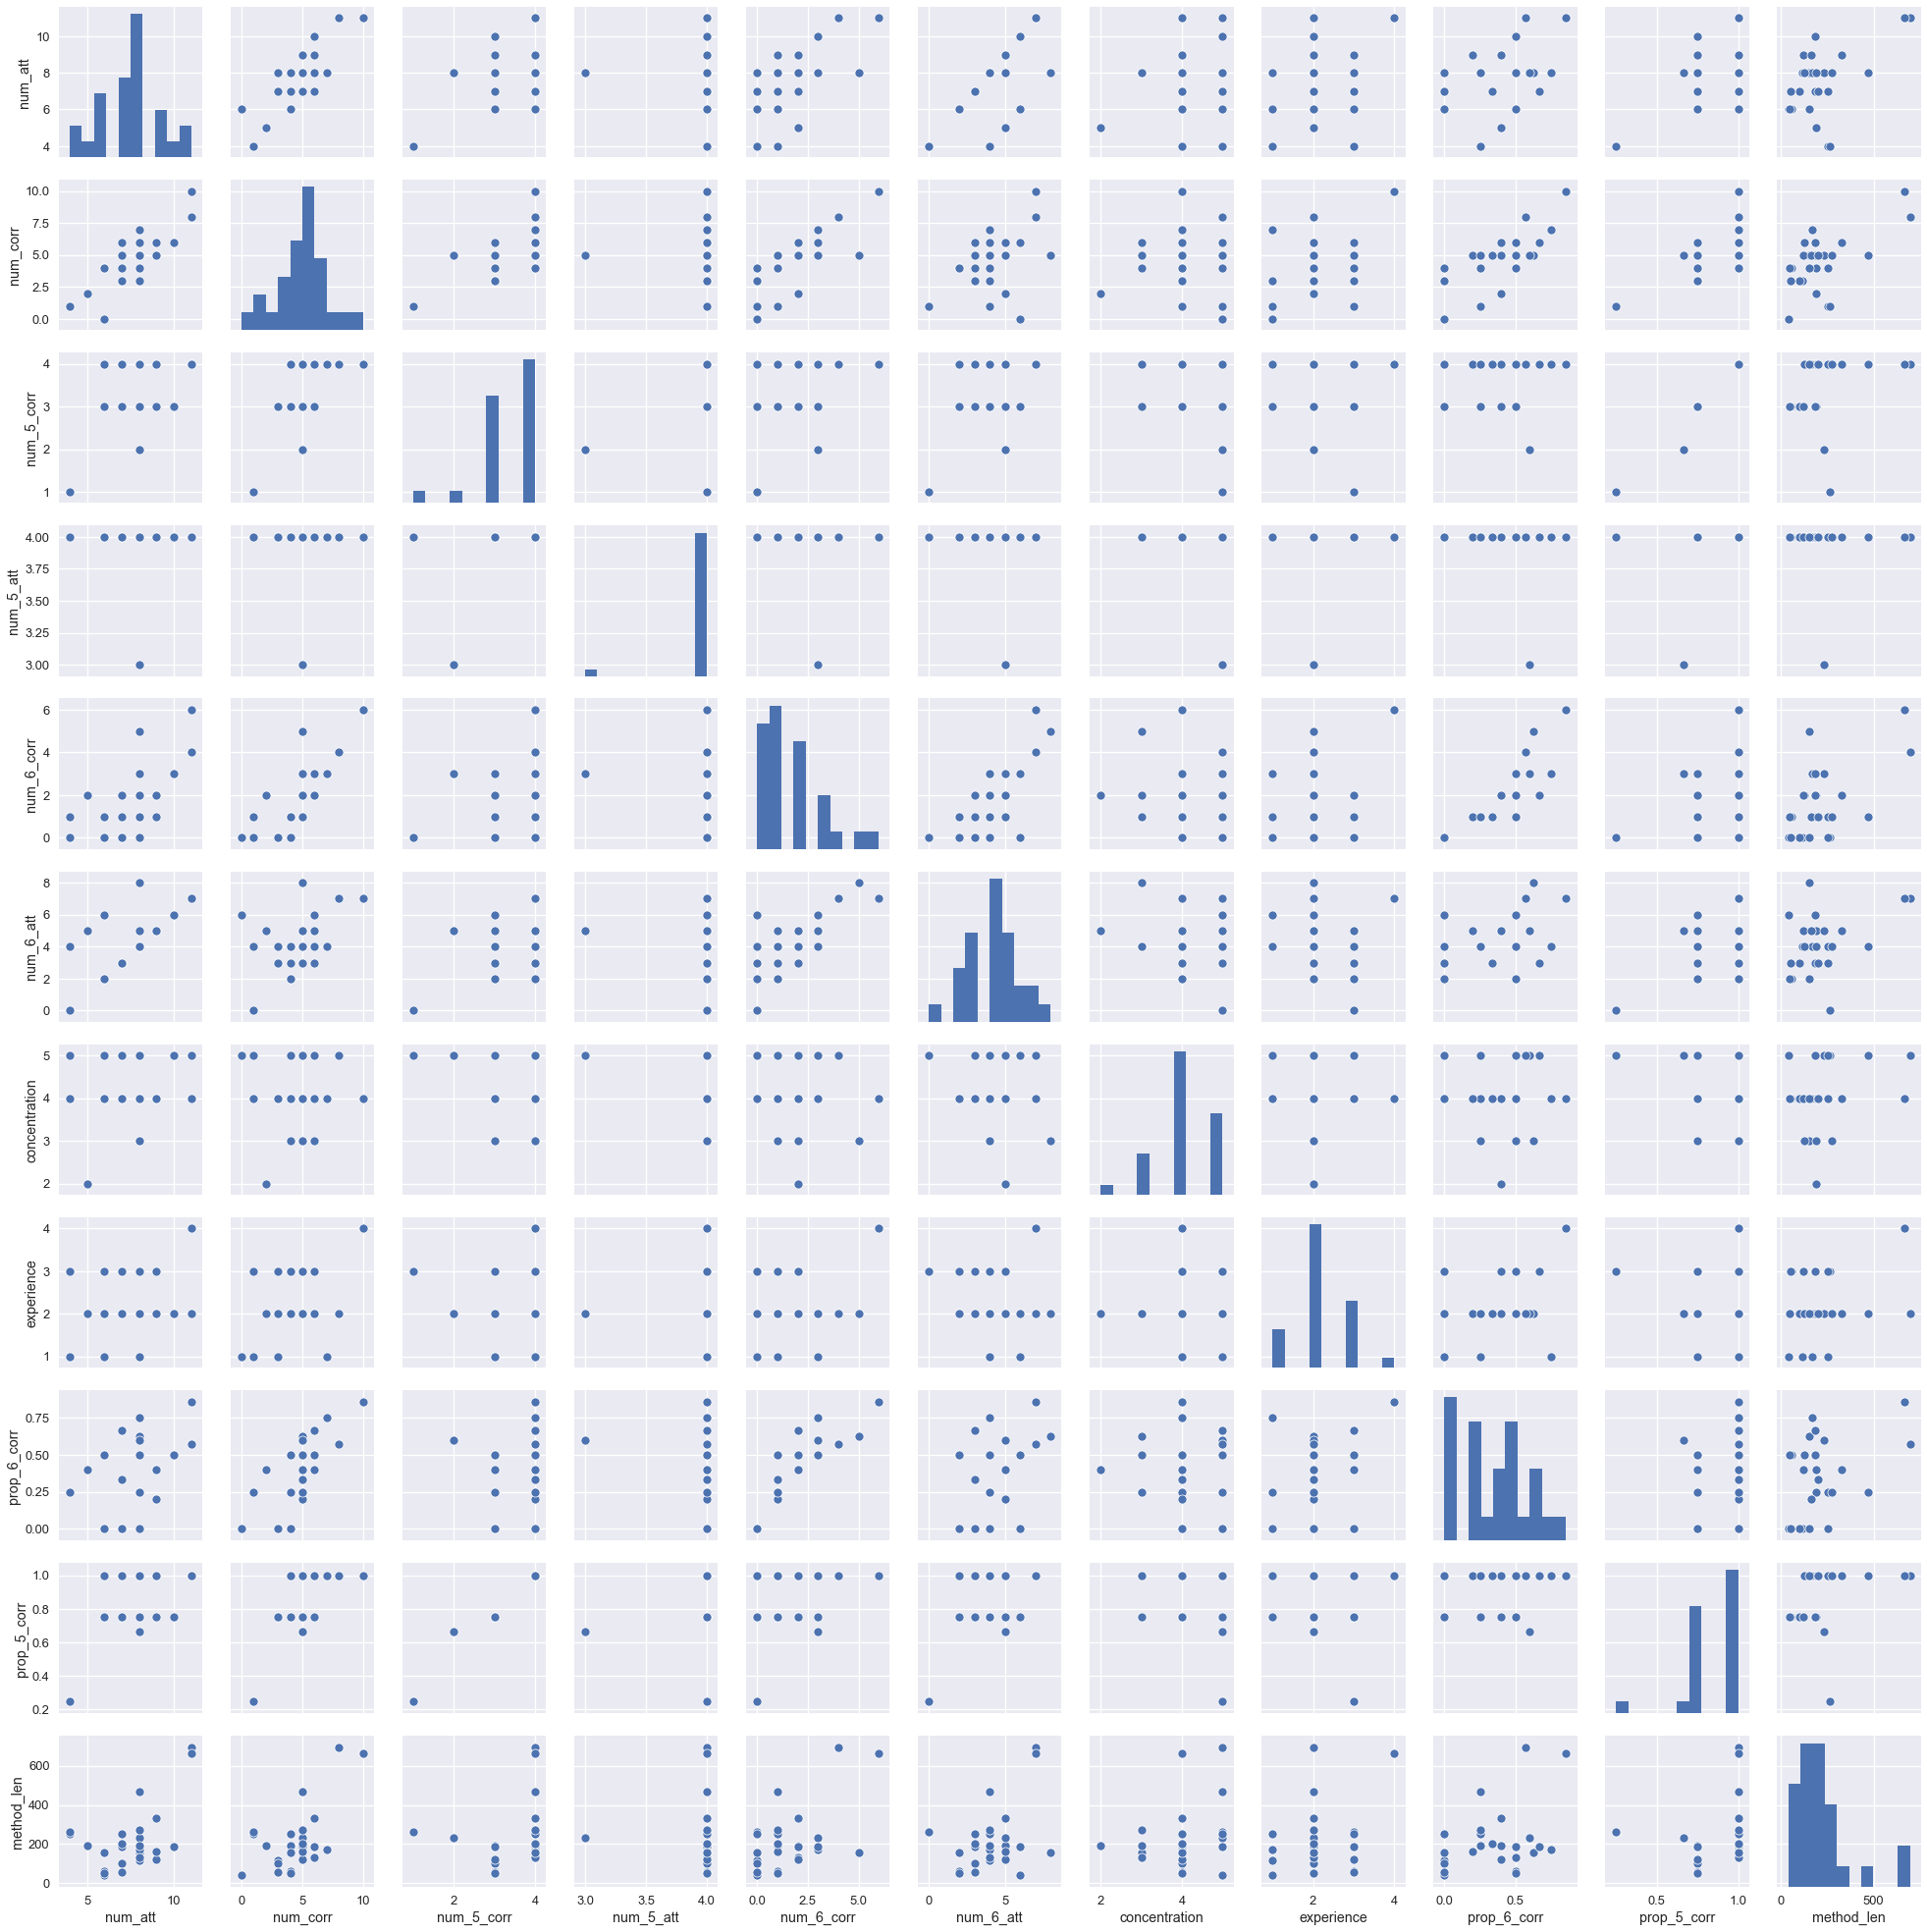

In [66]:
sns.pairplot(pars)

In [67]:
pars[4:].corr()

,num_att,num_corr,num_5_corr,num_5_att,num_6_corr,num_6_att,concentration,experience,prop_6_corr,prop_5_corr,method_len
num_att,1.000000,0.806028,0.452126,-0.023490,0.754780,0.991811,-0.013181,-0.031358,0.427443,0.482616,0.594226
num_corr,0.806028,1.000000,0.610078,-0.005135,0.910813,0.797664,0.006585,0.115764,0.795439,0.646231,0.649720
num_5_corr,0.452126,0.610078,1.000000,0.387488,0.228573,0.397564,-0.229068,-0.143684,0.050576,0.984892,0.297505
num_5_att,-0.023490,-0.005135,0.387488,1.000000,-0.208195,-0.150979,-0.276908,0.094388,-0.202844,0.221995,-0.005621
num_6_corr,0.754780,0.910813,0.228573,-0.208195,1.000000,0.772931,0.127438,0.217098,0.867081,0.280865,0.643288
num_6_att,0.991811,0.797664,0.397564,-0.150979,0.772931,1.000000,0.022342,-0.043065,0.452905,0.448856,0.588294
concentration,-0.013181,0.006585,-0.229068,-0.276908,0.127438,0.022342,1.000000,0.177258,0.141891,-0.190265,0.318281
experience,-0.031358,0.115764,-0.143684,0.094388,0.217098,-0.043065,0.177258,1.000000,0.220338,-0.169702,0.213666
prop_6_corr,0.427443,0.795439,0.050576,-0.202844,0.867081,0.452905,0.141891,0.220338,1.000000,0.111187,0.376656
prop_5_corr,0.482616,0.646231,0.984892,0.221995,0.280865,0.448856,-0.190265,-0.169702,0.111187,1.000000,0.315721


In [68]:
pars.vision.value_counts()

None                18
Glasses (Normal)     6
Contact Lenses       3
Name: vision, dtype: int64

In [69]:
pars.fluency.value_counts()

Fluent                 23
Working Profeciency     4
Name: fluency, dtype: int64

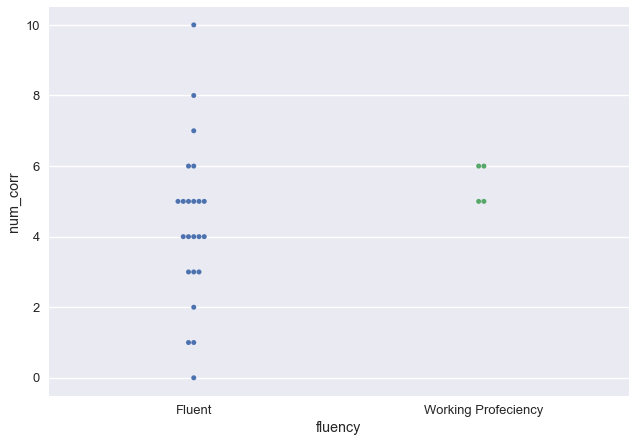

In [116]:
sns.swarmplot(pars.fluency, pars.num_corr)

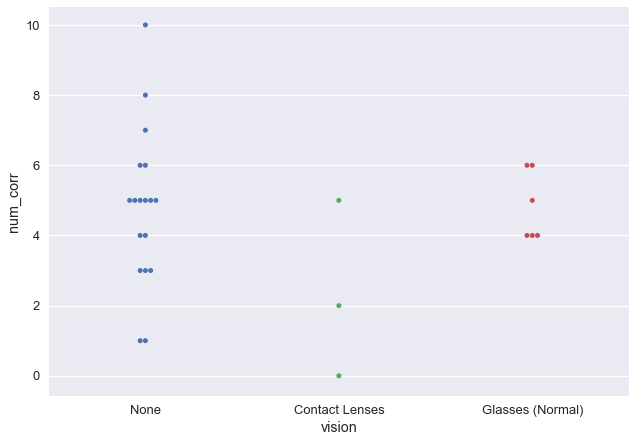

In [117]:
sns.swarmplot(pars.vision, pars.num_corr)
plt.show()

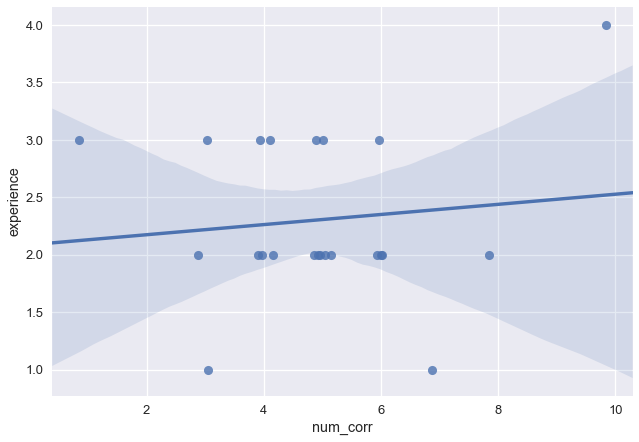

In [118]:
sns.regplot(pars.num_corr[4:], pars.experience[4:], x_jitter=0.2)
plt.show()

In [119]:
pars.num_corr[4:].corr(pars.experience[4:])

0.1157643818770217

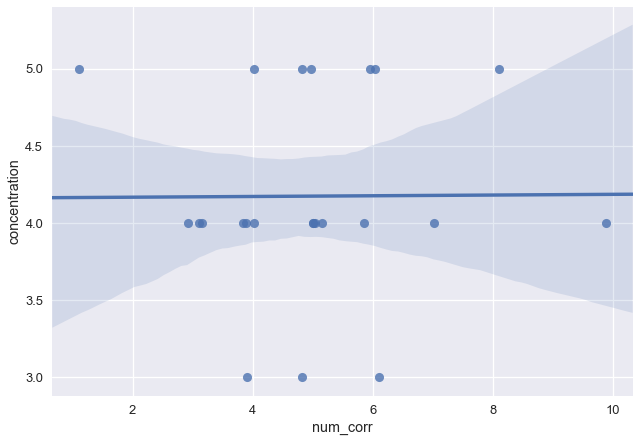

In [120]:
sns.regplot(pars.num_corr[4:], pars.concentration[4:], x_jitter=0.2)
plt.show()

In [75]:
pars.num_corr[4:].corr(pars.concentration[4:])

0.006585435097071524

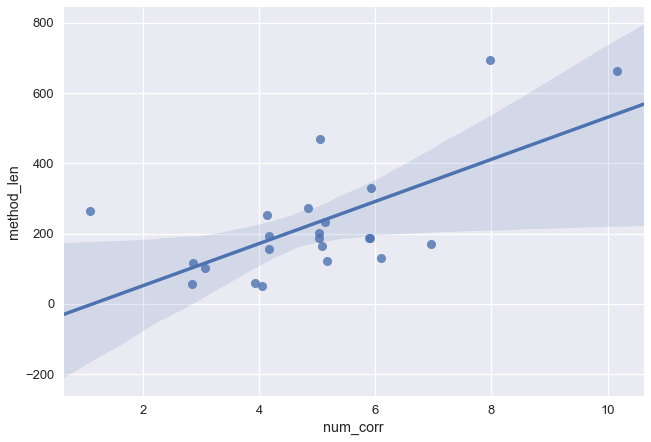

In [114]:
sns.regplot(pars.num_corr[4:], pars.method_len[4:], x_jitter=0.2)
plt.show()

In [77]:
pars.num_corr[4:].corr(pars.method_len[4:])

0.6497195376015735

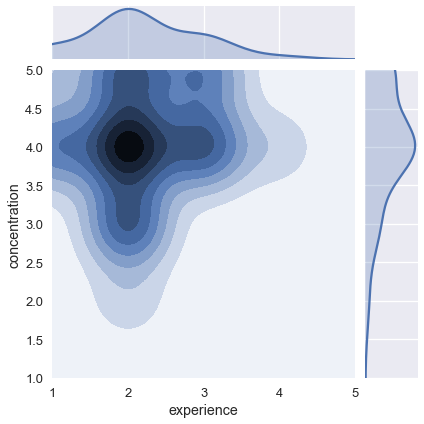

In [115]:
sns.jointplot(pars.experience, pars.concentration, kind='kde', xlim=(1,5), ylim=(1,5))
plt.show()

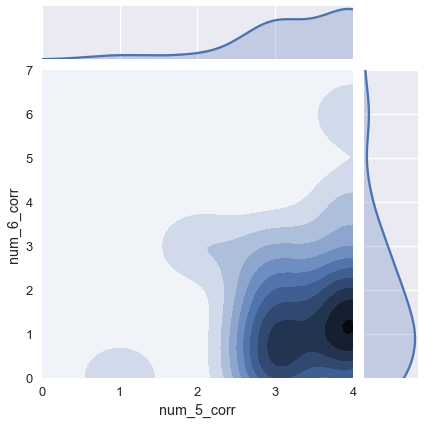

In [79]:
sns.jointplot(pars.num_5_corr[4:], pars.num_6_corr[4:], kind='kde', xlim=(0,4), ylim=(0,7))
plt.show()

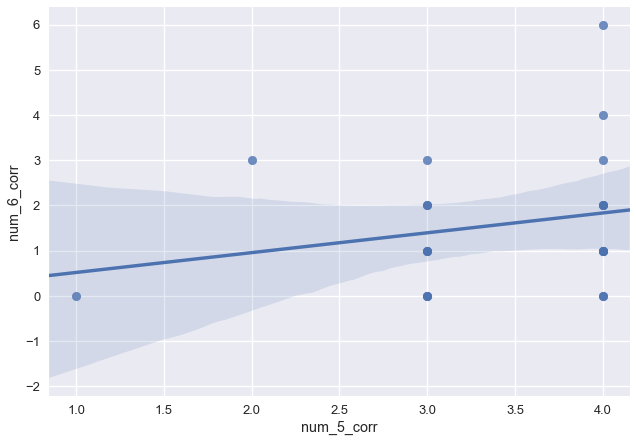

In [121]:
sns.regplot(pars.num_5_corr[4:], pars.num_6_corr[4:])

In [81]:
pars.num_5_corr[4:].corr(pars.num_6_corr[4:])

0.22857304267954048

In [122]:
y1 = average_list(one_first_locations_not)
y2 = average_list(one_first_locations)
err1 = statistics.stdev(one_first_locations_not) / (avg_size_one_first_not ** 0.5)
err2 = statistics.stdev(one_first_locations) / (avg_size_one_first ** 0.5)
plt.title('Average location of reading first bigram in solution word with standard deviation\n\
adjusted by the greater first bigram sampling size of non-solved anagrams')
plt.xlabel('solved')
plt.ylabel('percentage through')
sns.barplot(['not solved', 'solved'], [y1, y2], yerr=[err1, err2], ecolor='black', \
           capsize=0.2)
plt.show()

NameError: name 'one_first_locations_not' is not defined

In [ ]:
err1 = statistics.stdev(one_first_locations_not)
err2 = statistics.stdev(one_first_locations)
plt.title('Average location of reading first bigram in solution word with \n\
non-adjusted standard deviation')
plt.xlabel('solved')
plt.ylabel('percentage through')
sns.barplot(['not solved', 'solved'], [y1, y2], yerr=[err1, err2], ecolor='black', \
           capsize=0.2)
plt.show()

In [98]:
# make X_order

X_order = list()

for i in range(N):
    X_order.append(np.array(sequence_list_letter_order[i][1]))
    
X_order = np.array(X_order)

In [ ]:
sum(solved_list) / 202

In [85]:
# make the Y array
Y = np.array(solved_list)

In [86]:
# make the X_ones array 
X_ones = list()
for row in order_direction:
    X_ones.append(np.array(row))
X_ones = np.array(X_ones)
assert len(X_ones) == len(Y)
for row in X_ones:
    for i in range(len(row)):
        if row[i] != 1:
            row[i] = 0

In [87]:
len(sequence_list_letter_order[0][1])

286

In [88]:
X_ones[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [89]:
# make the X_words, X_wordlengths, X_wordlengths arrays

n_rows = len(sequence_list_letter)
X_words = np.zeros(n_rows)
X_wordlengths = np.zeros(n_rows)
X_par = np.zeros(n_rows)


for i in range(n_rows):
    letters = sequence_list_letter[i][0][4:]
    word = check_letters_word_list(letters, total_word_list)
    
    X_words[i] = total_word_list.index(word)
    X_wordlengths[i] = len(word)
    
    X_par[i] = int(sequence_list_letter[i][0][1:3])
    


In [90]:
X_seqlengths = np.zeros(len(sequence_list_letter))
for i in range(len(sequence_list_letter)):
    X_seqlengths[i] = len(sequence_list_letter[i][1])

In [91]:
# make X_bigrams, X_trigrams, X_fourgrams, and X_fivegrams

X_bigrams = [0] * n_rows
X_trigrams = [0] * n_rows
X_fourgrams = [0] * n_rows
X_fivegrams = [0] * n_rows
for gram_num in range(2, 6):
    for i in range(n_rows):

        letter_seq = sequence_list_letter[i][1]
        gram_length = len(letter_seq) - gram_num + 1
        gram_seq = [0] * gram_length
        for j in range(gram_length):
            gram_seq[j] = letter_seq[j] + letter_seq[j + 1]
            for k in range(2, gram_num):
                gram_seq[j] += letter_seq[j + k]

        gram_seq = np.array(gram_seq)

        if gram_num == 2:
            X_bigrams[i] = gram_seq
        elif gram_num == 3:
            X_trigrams[i] = gram_seq
        elif gram_num == 4:
            X_fourgrams[i] = gram_seq
        elif gram_num == 5:
            X_fivegrams[i] = gram_seq

X_bigrams = np.array(X_bigrams)
X_trigrams = np.array(X_trigrams)
X_fourgrams = np.array(X_fourgrams)
X_fivegrams = np.array(X_fivegrams)

## Grams

In [92]:
# make the `bigrams_for_words` which contains the total list of bigrams read for each word 
from itertools import permutations 

def make_grams(n_grams):
    grams_for_words = [0] * len(total_word_list)
    for num in range(len(grams_for_words)):
        grams_for_words[num] = list()
    for i in range(n_rows):
        index = int(X_words[i])
        if n_grams == 2:
            gram_seq = X_bigrams[i]
        elif n_grams == 3:
            gram_seq = X_trigrams[i]
        elif n_grams == 4:
            gram_seq = X_fourgrams[i]
        elif n_grams == 5:
            gram_seq = X_fivegrams[i]
        for j in range(len(gram_seq)):
            grams_for_words[index].append(gram_seq[j])

    possible_grams_for_words = list()
    possible_gram_counts_for_words = list()
    total_gram_counts = list()
    for i in range(len(total_word_list)):
        possible_grams = list(permutations(total_word_list[i], r=n_grams)) 
        possible_grams = [''.join(combo) for combo in possible_grams]
        possible_gram_counts = list()
        for gram in possible_grams:
            possible_gram_counts.append(grams_for_words[i].count(gram))

        possible_grams_for_words.append(possible_grams)
        possible_gram_counts_for_words.append(possible_gram_counts)
        total_gram_counts.append(len(grams_for_words[i]))
    
    for i in range(len(total_word_list)):
        ordering = list(np.argsort(np.array(possible_gram_counts_for_words[i])))
        possible_grams_for_words[i] = [possible_grams_for_words[i][index] for index in ordering]
        possible_gram_counts_for_words[i] = [possible_gram_counts_for_words[i][index] for index in ordering]
    
    return possible_grams_for_words, possible_gram_counts_for_words, total_gram_counts
    


In [93]:
possible_bigrams_for_words, possible_bigram_counts_for_words, total_bigram_counts = make_grams(2)
possible_trigrams_for_words, possible_trigram_counts_for_words, total_trigram_counts = make_grams(3)

In [ ]:
def plot_top_grams(n_grams, top_amount=None):
    if top_amount is None:
        show_all = True
    possible_grams, possible_gram_counts, total_gram_counts = make_grams(n_grams)
    for i in range(len(possible_grams)):
        if show_all:
            top_amount = len(possible_grams[i])
        plt.figure(figsize=(8, top_amount * 0.22))
        plt.barh(possible_grams[i][- top_amount:], \
                possible_gram_counts[i][- top_amount:])
        plt.title(str.lower(total_word_list[i]) + ' ' + str(total_gram_counts[i]) + ' ' + 'grams' \
                  + ', ' + str(len(possible_grams[i])) + ' possible, top ' + str(top_amount) + ' shown')
        plt.show()

In [ ]:
# plot_top_grams(n_grams=2)

In [ ]:
# plot_top_grams(n_grams=3)

## Simple Classifier


In [ ]:
num_short = 0
for value in X_seqlengths:
    if value < 12:
        num_short += 1
        
print(num_short)

In [ ]:
X_last_ones = list()
Y_last_ones = list()
for i in range(len(Y)):
    if X_seqlengths[i] >= 13:
        X_last_ones.append(X_ones[i][-8:])
        Y_last_ones.append(Y[i])
        
X_last_ones = np.array(X_last_ones)
Y_last_ones = np.array(Y_last_ones)

In [ ]:
N = len(X_last_ones)
Y_hot_last_ones = np.zeros((N, 2))

for i in range(N):
    Y_hot_last_ones[i, Y_last_ones[i]] = 1  # if is a 0, it puts a 1 in the 0th column, etc. 
                               # position for that row (1 hot encoding) - JM
#     X_last_ones[i] = X_last_ones[i]-np.mean(X_last_ones[i]) # 0-mean
#     X_last_ones[i] = X_last_ones[i]/np.sqrt(np.sum(X_last_ones[i]**2)) # makes each data point z-score/like - JM

In [ ]:
# plt.imshow(Y_hot_last_ones[25:30])
# plt.show()
# plt.imshow(X_last_ones[25:30])
# plt.show()
np.shape(X_last_ones)

In [ ]:
from sklearn.metrics import confusion_matrix
# Comparison with the simplistic idea.
nPat, dim = np.shape(X_last_ones)
avg_solutions = np.zeros((2,dim))
# avg_images = np.zeros((2,8))
counts = np.zeros(2)

# The two for loops below get the average of the brightness values on the images for each digit.
# I'm not sure why there's two cases (digits and images), when they're realy the same thing, just
# in an 8 by 8 matrix versus a 64 length array. - JM
for i in range(nPat):
    j = Y_last_ones[i]
    avg_solutions[j,:] = avg_solutions[j,:] + X_last_ones[i,:]
#     avg_images[j,:,:] = avg_images[j,:,:]+np.reshape(X[i,:],(8,8))
    counts[j] = counts[j]+1

    # JM
#     if i == 0:
#         print(avg_digits[5,:])
#         print(avg_images[5:,:])
        
for j in range(2):
    avg_solutions[j,:] = avg_solutions[j,:]/counts[j]
#     avg_images[j,:] = avg_images[j,:]/counts[j]

print(counts)

# I suppose this answers my previous question, avg_images is for displaying the average brightness
# values for each image in the imshows below. - JM
# for j in range(10):
#     plt.subplot(2,5,j+1)
#     plt.imshow(avg_images[j,:,:])
# plt.show()

# Calculate distance from mean.
Y_avg_pred = np.zeros(nPat)  # empty prediction array - JM
for i in range(nPat):
    dist = np.zeros(2)  # empty array for putting sum of sq of errors btw the avg for each digit
                         # and the image (i) - JM
    for j in range(2):
        dist[j] = np.sum((X_last_ones[i,:]-avg_solutions[j,:])**2)  # for each coordinate on the image, get 
                                                       # the square of the difference from the
                                                       # average for each digit. - JM
        # JM testing
#         if i == 0:
#             if j == 9:
#                 print('JM -', np.argmin(dist), dist, '- JM')  
            
    Y_avg_pred[i] = np.argmin(dist)  # Pick the one with the lowest sum of squared errors. - JM
cm = confusion_matrix(Y_last_ones, Y_avg_pred) 
print(cm)
# Sum the number of correct predictions divided by the total number of predictions
print('Performance = %3.5f'%(np.sum(np.diagonal(cm))/np.sum(cm))) 


In [ ]:
106 / (106 + 80)

In [ ]:
print(avg_solutions[0], sum(avg_solutions[0]))

In [ ]:
print(avg_solutions[1], sum(avg_solutions[1]))

## Neural Network

In [ ]:
# MLP using sklearn.
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(activation='logistic', max_iter=100000,
                    hidden_layer_sizes=(), random_state=0)
clf.fit(X_last_ones, Y_hot_last_ones)
Y_pred = clf.predict(X_last_ones)
Y_pred_label = np.argmax(Y_pred,axis=1)

cm = confusion_matrix(Y_last_ones,Y_pred_label)
print(cm)
print('Performance = %3.5f'%(np.sum(np.diagonal(cm))/np.sum(cm)))

In [ ]:
last_eight_bigrams = list(range(1,9))
plt.title('proportion of in-word bigrams for last eight bigrams, by solved')
plt.plot(last_eight_bigrams, avg_solutions[0], label='not solved')
plt.plot(last_eight_bigrams, avg_solutions[1], label='solved')
plt.legend()
plt.show()

## Simple one proportion

In [78]:
X_one_prop = np.zeros(len(X_ones))


In [79]:
for i in range(len(X_ones)):
    X_one_prop[i] = np.sum(X_ones[i]) / len(X_ones[i])

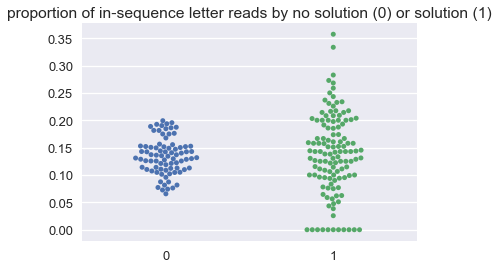

In [80]:
plt.title('proportion of in-sequence letter reads by no solution (0) or solution (1)')
sns.swarmplot(x=Y, y=X_one_prop)

In [81]:
wrong = list()
right = list()
for i in range(len(X_one_prop)):
    if Y[i] == 0:
        wrong.append(X_one_prop[i])
    else:
        right.append(X_one_prop[i])


In [82]:
avg_median_stdev_skewness(wrong)

NameError: name 'avg_median_stdev_skewness' is not defined

In [83]:
avg_median_stdev_skewness(right)

NameError: name 'avg_median_stdev_skewness' is not defined

In [ ]:
backtrack = 5
order_direction5b = list()
order_direction6b = list()
for row in sequence_list_letter_order:
    length = len(row[1]) - 1
    for i in range(length):
        if i > length - backtrack:
            v = row[1][i + 1] - row[1][i]
            # if six letter word
            if len(row[0]) == 10:
                order_direction6b.append(v)
            # if five letter word
            elif len(row[0]) == 9:
                order_direction5b.append(v)


In [ ]:
# Not finished, trying to weight the order direction by the direction
ord_dir_comb_5 = list()
for i in range(len(direction5)):
    index = x5.index(direction5[i])
    ord_dir_comb_5.append([order_direction5[i], direction5[i], y5[index]])

In [107]:
def outcome_list_to_prob_mass(outcome_list, proportion=1):
    x = []
    y = []
    length = len(outcome_list)
    unique_outcomes = list(set(outcome_list))
    for result in unique_outcomes:
        num_counts = outcome_list.count(result)
        x.append(result)
        y.append(num_counts / length)
    if proportion != 1:
        y = [value * proportion for value in y]
    return x, y


def plot_prob_mass(x, y, title, xlabel, ylabel, save=False, default_x_ticks=False, no_labels=False):
    plt.style.use('seaborn')
    plt.style.use('seaborn-talk')
    if default_x_ticks == False:
        plt.xticks(x)
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    if no_labels == False:
        for a, b in zip(x, y):
            if b != 0:
                plt.text(a, b, "{:0.1%}".format(b), ha='center', va='bottom', size=11)
    if save == True:
        plt.savefig(title + '.png', dpi=300)
    plt.show()
    

def histJM(outcome_list, title="", xlabel="", ylabel="proportion"):
    x, y = outcome_list_to_prob_mass(outcome_list)
    plot_prob_mass(x, y, title=title, \
               xlabel=xlabel, ylabel=ylabel)


def average_list(outcome_list):
    return sum(outcome_list) / len(outcome_list)
       

def avg_median_stdev_skewness(outcome_list):
    print('Average', average_list(outcome_list))
    print('Median', statistics.median(outcome_list))
    print('St.Dev', statistics.stdev(outcome_list))
    print('Skewness', skew(outcome_list))

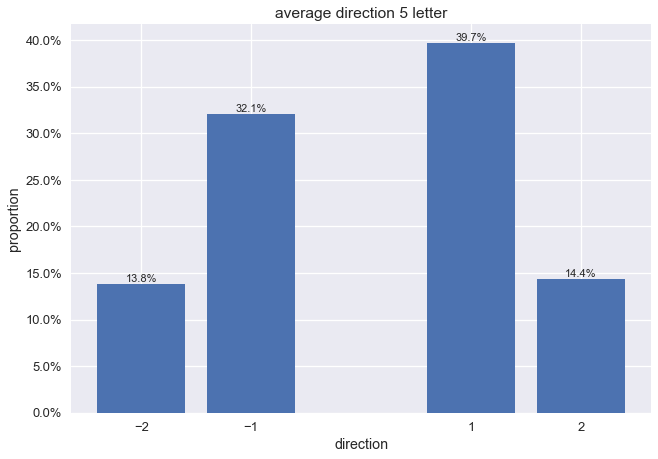

In [265]:
x5, y5 = outcome_list_to_prob_mass(direction5)
plot_prob_mass(x5, y5, title='average direction 5 letter', xlabel='direction', ylabel='proportion')

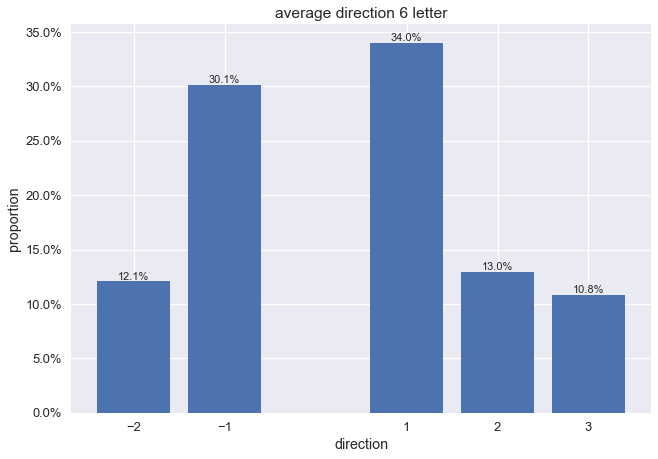

In [61]:
x6, y6 = outcome_list_to_prob_mass(direction6)
plot_prob_mass(x6, y6, title='average direction 6 letter', xlabel='direction', ylabel='proportion')

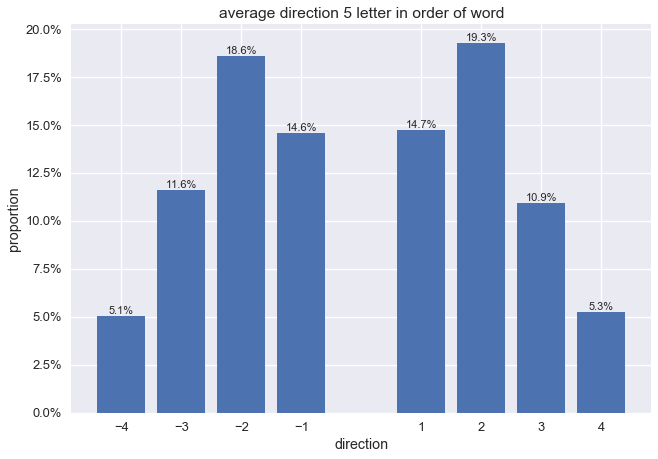

In [62]:
x5_ord, y5_ord = outcome_list_to_prob_mass(order_direction5)
plot_prob_mass(x5_ord, y5_ord, title='average direction 5 letter in order of word', \
               xlabel='direction', ylabel='proportion')

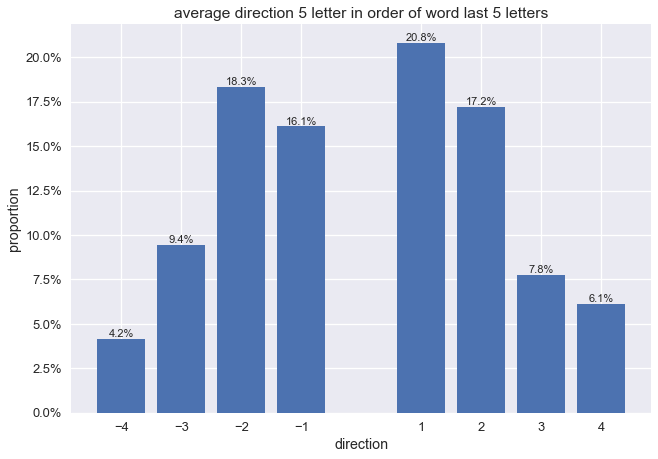

In [63]:
histJM(order_direction5b, title='average direction 5 letter in order of word last 5 letters', \
               xlabel='direction')

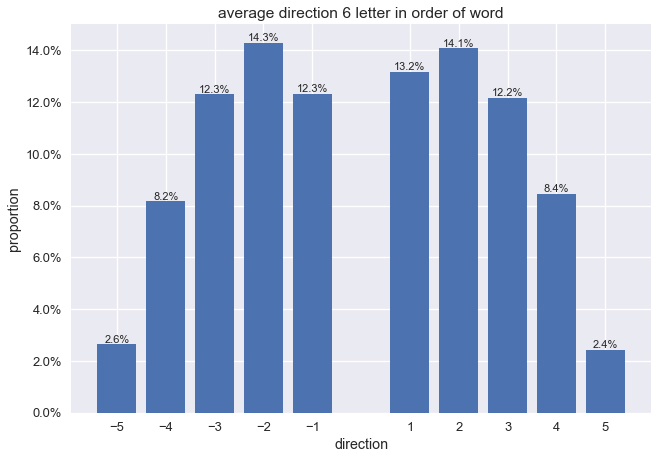

In [64]:
x6_ord, y6_ord = outcome_list_to_prob_mass(order_direction6)
plot_prob_mass(x6_ord, y6_ord, title='average direction 6 letter in order of word', \
               xlabel='direction', ylabel='proportion')

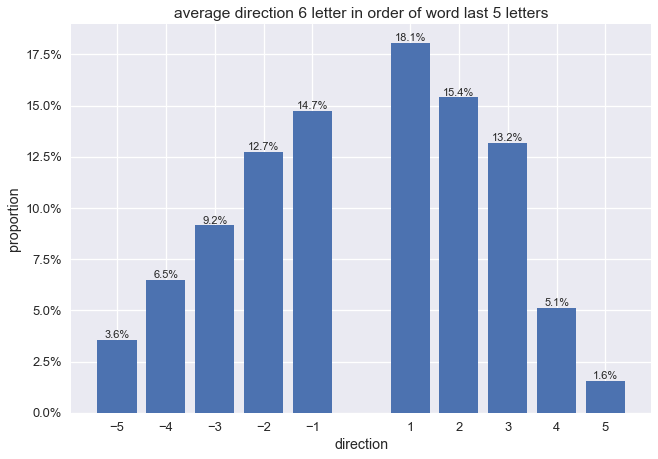

In [65]:
histJM(order_direction6b, title='average direction 6 letter in order of word last 5 letters', \
               xlabel='direction')

In [455]:
sequence_lengths = list()
sequence_lengths0 = list()
sequence_lengths1 = list()
sequence_lengths1_5 = list()
sequence_lengths1_6 = list()
for row in sequence_list_letter:
    sequence_lengths.append(len(row[1]))
    if row[2] == 0:
        sequence_lengths0.append(len(row[1]))
    elif row[2] == 1:
        sequence_lengths1.append(len(row[1]))
        if len(row[0]) == 9:
            sequence_lengths1_5.append(len(row[1]))
        elif len(row[0]) == 10:
            sequence_lengths1_6.append(len(row[1]))

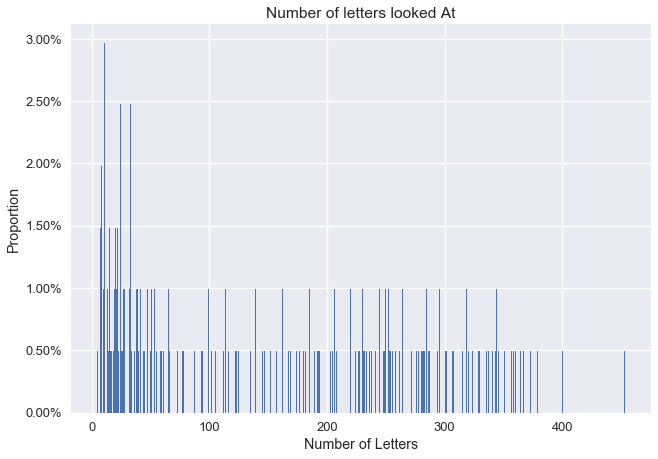

In [390]:
lenx, leny = outcome_list_to_prob_mass(sequence_lengths)

plot_prob_mass(lenx, leny, title='Number of letters looked At', xlabel='Number of Letters', \
               ylabel='Proportion', default_x_ticks=True, no_labels=True)

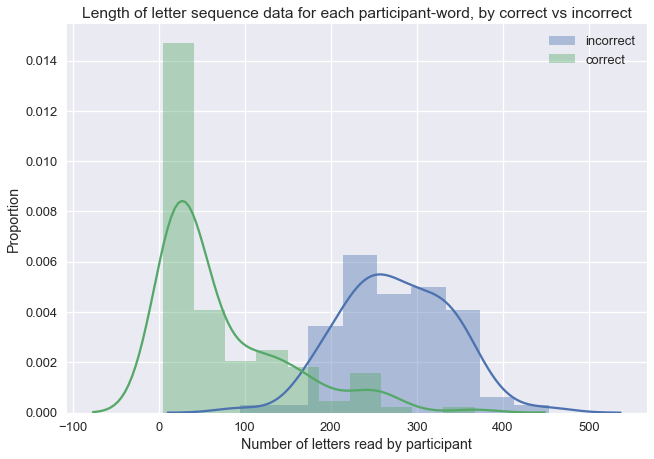

In [394]:
plt.title('Length of letter sequence data for each participant-word, by correct vs incorrect')
plt.xlabel('Number of letters read by participant')
plt.ylabel('Proportion')
sns.distplot(sequence_lengths0, label='incorrect')
sns.distplot(sequence_lengths1, label='correct')
plt.legend()
# sns.kdeplot(sequence_lengths, shade=True)
plt.savefig('sequence_length_histogram_solved' + '.png', dpi=300)

In [446]:
avg_median_stdev_skewness(sequence_lengths1)

Average 72.56557377049181
Median 39.0
St.Dev 74.45282356815873
Skewness 1.5280765272895125


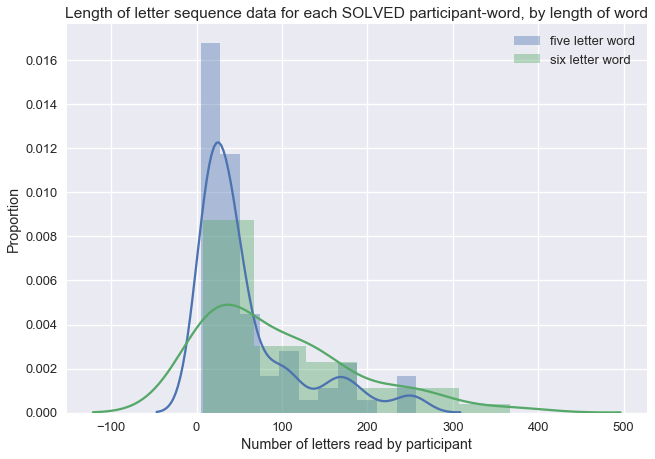

In [458]:
plt.title('Length of letter sequence data for each SOLVED participant-word, by length of word')
plt.xlabel('Number of letters read by participant')
plt.ylabel('Proportion')
sns.distplot(sequence_lengths1_5, label='five letter word')
sns.distplot(sequence_lengths1_6, label='six letter word')
plt.legend()
# sns.kdeplot(sequence_lengths, shade=True)
plt.savefig('sequence_length_histogram_solved_5_6' + '.png', dpi=300)

In [459]:
avg_median_stdev_skewness(sequence_lengths1_5)

Average 58.97435897435897
Median 33.5
St.Dev 61.95682920105486
Skewness 1.670225629195315


In [460]:
avg_median_stdev_skewness(sequence_lengths1_6)

Average 96.6590909090909
Median 65.5
St.Dev 88.29178454283833
Skewness 1.1282121744398463


In [70]:
# par_word = pd.DataFrame(list(range(len(par_word_list))), index=par_word_list)

In [71]:

par_word_list = list()
for row in sequence_list:
    par_word_list.append(row[0])

In [72]:
# pd.set_option('display.max_rows', 205)
# par_word.to_csv('participant_words.csv')
# par_word

In [73]:
# get the sequence list as strings for some reason
sequence_list_str = list()
for row in sequence_list:
    sequence_list_str.append([row[0], [str(value) for value in row[1]]])

The ideal dataframe from which we can make predictions will depend on what we're trying to predict. 
For example, if we're trying to predict whether the participant gets the anagram correct, then we we will want correct/incorrect to be a column value. Because one can only get an anagram correct or incorrect, the anagrams will have to be the rows. As a result, there will be around 200 rows. We will have columnns other than correct/incorrect. 

In [ ]:
# # histograms for how many times each letter is looked at
# for column in sequence_data:
#     sequence_data[column].hist()
#     plt.title(column)
#     plt.show()

In [75]:
# participant 11 solved brown very fast and didn't seem to look at all of them 'BNRWO'
# remove 'WRNOB' because apparently moved past by mistake (particpant 6)
# later look to see if time or number of fixations till a solution goes down as participant number goes up 
# to check for possible cheating 

# manual_remove = ['EATCJK', 'EUKMPA', 'GNSOAL', 'MLRNAO', 'YSMOTR', 'TENUAP', 'UMKPAE', 'RWBON', 'WRNOB', 'none']

In [79]:
# total_data_sequence1.columns

In [77]:
total_data.ParticipantName.unique()

array(['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P22', 'P17', 'P18',
       'P20', 'P21', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29'],
      dtype=object)

In [80]:
total_data_sequence1['P09_CKAHL'].loc[total_data_sequence1['P09_CKAHL'] >=0].plot()

NameError: name 'total_data_sequence1' is not defined

In [81]:
pd.set_option('display.max_columns', 350)
total_data.groupby(['ParticipantName', 'MediaName']).RecordingTimestamp.min()

ParticipantName  MediaName        
P01              123456                  878.0
                 ARDIEM               196733.0
                 IUJONR               413305.0
                 KUMEPA               671796.0
                 LEADFW                76289.0
                                        ...   
P29              REABYT               425437.0
                 RNOBW                 79011.0
                 TDMSOE               621124.0
                 black_break_image     89786.0
                 none                      3.0
Name: RecordingTimestamp, Length: 301, dtype: float64

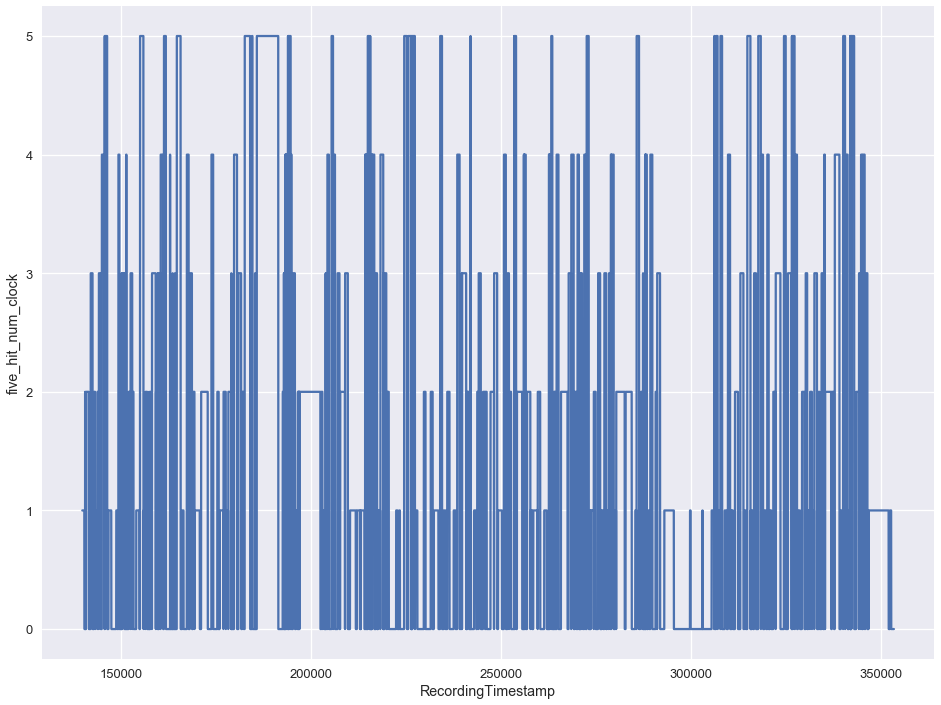

In [82]:
# total_data.groupby(['ParticipantName', 'MediaName']).five_hit_num_clock.max()

plt.figure(figsize=(16,12))
y_data = total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'OEPRW']
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_hit_num_clock)

In [ ]:
total_data.groupby('ParticipantName').MediaName.unique()

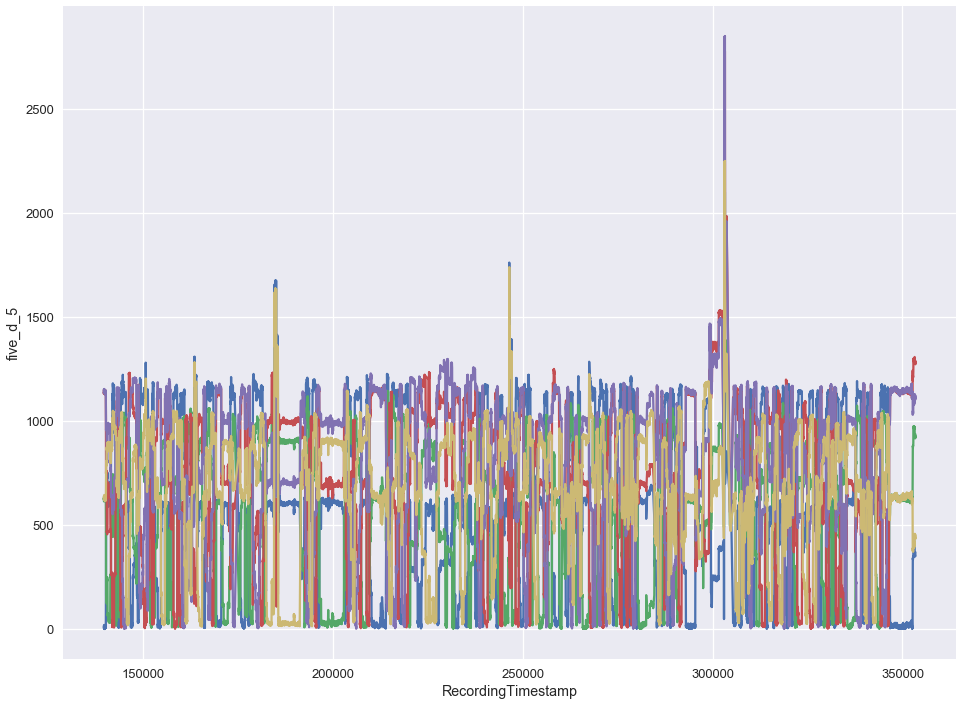

In [265]:

plt.figure(figsize=(16,12))
# total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'AKCLH'].\
# plot(x='RecordingTimestamp', y=['five_d_1', 'five_d_2', 'five_d_3', 'five_d_4', 'five_d_5'])

y_data = total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'OEPRW']
# plt.ylim(top=143)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_1)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_2)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_3)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_4)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_5)





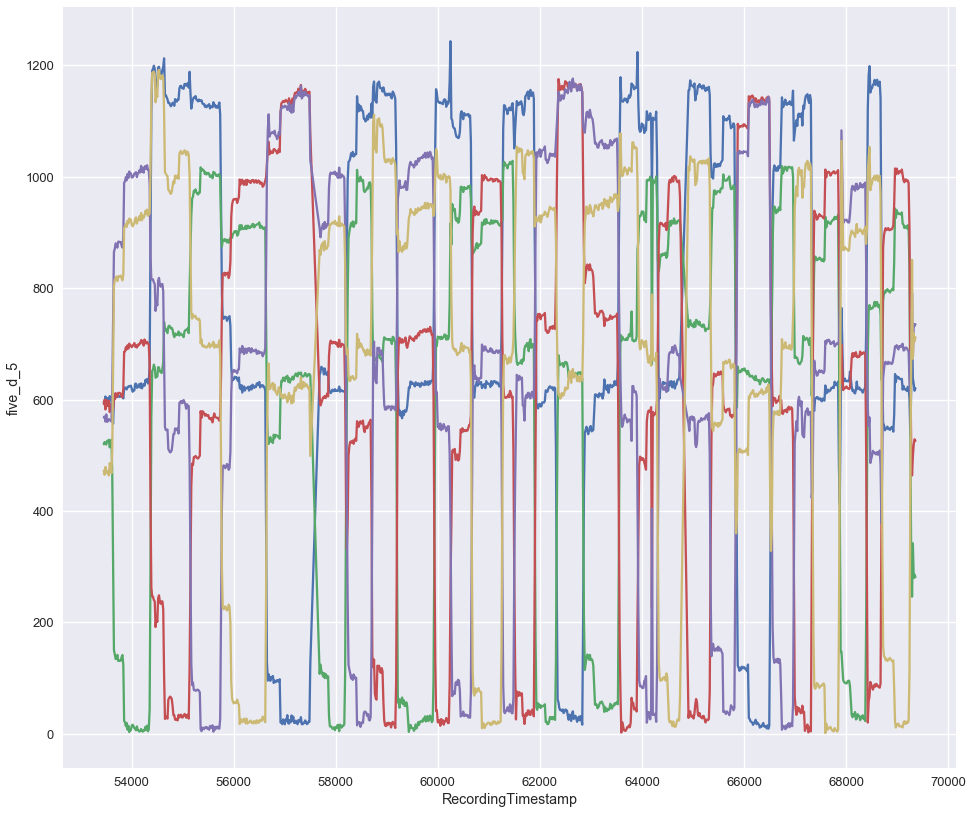

In [264]:

plt.figure(figsize=(16,14))
# total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'AKCLH'].\
# plot(x='RecordingTimestamp', y=['five_d_1', 'five_d_2', 'five_d_3', 'five_d_4', 'five_d_5'])

y_data = total_data.loc[total_data.ParticipantName == 'P25'].loc[total_data.MediaName == 'HLACK']
# plt.ylim(top=143)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_1)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_2)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_3)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_4)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_5)


In [ ]:
"""
The next step is probably to get a rudimentary generation of the letter sequence data. We can refine it later to 
reflect things like fixation, etc. 

Then we would have a pandas sheet that does not go by timestamp, rather it be ~ 400 rows and just be the MediaName
for each participant. One of the columns would have a number sequence from middle left going clockwise starting with 
the number 1. Which, based on the order of the letters for the word, could be converted to 1-5 or 1-6 in terms of the 
order of the letter in the word, 0-1 for consonant or vowel, or could be letters just representing the letter they're
looking at. 
We would fill in this pandas sheet with all the information about the participant, listed on the github README:
1 or 0 for correct or incorrect, list of guesses, experience with anagrams, etc. We could even add male/female. 

"""

In [ ]:

plt.figure(figsize=(16,14))
# total_data.loc[total_data.ParticipantName == 'P28'].loc[total_data.MediaName == 'AKCLH'].\
# plot(x='RecordingTimestamp', y=['five_d_1', 'five_d_2', 'five_d_3', 'five_d_4', 'five_d_5'])

y_data = total_data.loc[total_data.ParticipantName == 'P25'].loc[total_data.MediaName == 'HLACK']
# plt.ylim(top=143)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_1)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_2)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_3)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_4)
sns.lineplot(x=total_data.RecordingTimestamp, y=y_data.five_d_5)





In [83]:
sequence_time_data

ParticipantMedia,P01_123456,P01_ARDIEM,P01_IUJONR,P01_KUMEPA,P01_LEADFW,P01_MDTOSE,P01_PNEUTA,P01_RYEABT,P01_SCODLE,P02_123456,P02_AFDWLE,P02_CEOLDS,P02_IAMEDR,P02_NOJUIR,P03_123456,P03_CSOELD,P03_JIUORN,P03_RAIMED,P03_WFEADL,P03_YRBATE,P04_123456,P04_ATEYRB,P04_DIEMAR,P04_ELCSDO,P04_INOJRU,P04_LAEFDW,P04_TNPUAE,P05_123456,P05_DEMIAR,P05_DLEFAW,P05_OESLDC,P06_123456,P06_ABRYET,P06_EODLSC,P06_IMEARD,P06_LDFAEW,P06_NOUJIR,P07_123456,P07_AELDWF,P07_LSODCE,P08_123456,P08_FLEADW,P08_IEDRAM,P08_SCOELD,P08_URJNOI,P09_123456,P09_BERYTA,P09_DEMAIR,P09_DLEFWA,P09_ECDOSL,P09_RNJIOU,P10_123456,P10_ADWFEL,P10_LDOCES,P10_RIAMED,P10_UIOJNR,P11_123456,P11_ECSDOL,P11_IJNROU,P11_LWFADE,P11_RAEIDM,P12_123456,P12_ADLWEF,P12_CDOELS,P12_DIMEAR,P13_123456,P13_ARMEDI,P13_AWFELD,P13_OELCSD,P13_OJIURN,P14_123456,P14_ARMEDI,P14_AWFELD,P14_OELCSD,P14_OJIURN,P15_123456,P15_AIRDEM,P15_IJOUNR,P15_SDOELC,P15_WLFEAD,P17_123456,P17_DLEOCS,P17_EMRDIA,P17_LWAEFD,P17_NEUTAP,P17_RIUOJN,P17_TABREY,P18_123456,P18_ADWFLE,P18_EATRBY,P18_LCSDOE,P18_MRAEID,P18_URNJOI,P20_123456,P20_DSCLEO,P20_EDIRMA,P20_ELWDAF,P20_JIRUNO,P20_TAREYB,P21_123456,P22_123456,P22_DLSEOC,P22_EFADLW,P22_RAIEDM,P22_RIJNOU,P22_SOTDEM,P22_TAPUNE,P22_YBTAER,P23_123456,P23_CDOSLE,P23_LEWFAD,P23_MIEDRA,P24_123456,P24_EIADRM,P24_ELDAFW,P24_OCSELD,P25_123456,P25_AFDLWE,P25_ESLDOC,P25_MEIADR,P25_NRUIOJ,P26_123456,P26_EAFWLD,P26_ELDOSC,P27_123456,P27_IDEMAR,P27_OECSLD,P27_WFEALD,P28_123456,P28_OLDSCE,P28_WDFEAL,P29_123456,P29_DWLEFA,P29_IMEDRA,P29_JIRNOU,P29_NTEUAP,P29_ODLSCE,P29_REABYT,P29_TDMSOE,P05_12345,P05_BWRNO,P05_CLHKA,P05_ROEPW,P05_TORCU,P06_12345,P06_HKCAL,P06_ROTCU,P06_WRPEO,P07_12345,P07_LCAKH,P07_ONRWB,P07_ORUCT,P07_ORWPE,P08_12345,P08_AKHLC,P08_ORPWE,P08_OWRNB,P08_UORCT,P09_12345,P09_BOWRN,P09_CKAHL,P09_EWPRO,P09_OTCUR,P10_12345,P10_CALHK,P10_CTUOR,P10_NBWRO,P10_PWROE,P11_12345,P11_BNRWO,P11_CUTOR,P11_HLCAK,P11_PRWOE,P12_12345,P12_KHLCA,P12_ROTUC,P12_RWOEP,P13_12345,P13_KAHLC,P13_OEPWR,P13_ORWBN,P13_OUTCR,P14_12345,P14_KAHLC,P14_OEPWR,P14_ORWBN,P14_OUTCR,P15_12345,P15_LHAKC,P15_OEWPR,P15_UCTOR,P15_WRONB,P17_12345,P17_LHKCA,P17_OBWRN,P17_TORUC,P17_WROEP,P18_12345,P18_CLHAK,P18_TCROU,P18_WBONR,P18_WPROE,P20_12345,P20_CKHLA,P20_EPRWO,P20_OBNRW,P20_TUORC,P21_12345,P21_EORWP,P21_LACKH,P21_ORCTU,P21_WOBNR,P22_12345,P22_HAKCL,P22_NOBWR,P22_OWRPE,P22_RUCTO,P23_12345,P23_CUROT,P23_HKACL,P23_RONBW,P23_WPEOR,P24_12345,P24_EORPW,P24_LHKAC,P24_TCURO,P24_WBNOR,P25_12345,P25_CROUT,P25_HLACK,P25_RWBNO,P25_WOEPR,P26_12345,P26_KACLH,P26_RWOBN,P26_TUCRO,P26_WEORP,P27_12345,P27_ALHKC,P27_PEORW,P27_ROUTC,P27_WRNBO,P28_12345,P28_AKCLH,P28_BNORW,P28_OEPRW,P28_UROTC,P29_12345,P29_HLCKA,P29_PEOWR,P29_RCTUO,P29_RNOBW
MediaTimestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,2.0,2.0
15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [285]:
time_list = list()
for value in sequence_time_data.index:
    time_list.append(value)

# change milliseconds to seconds
# time_list = [value / 1000 for value in time_list]

In [286]:
# Get the letter (number) sequences from the sequence_time_data dataframe
sequence_td_list = list()
for column in sequence_time_data:
    temp_seq_list = list(sequence_time_data[column])
    sequence_td_list.append([column, temp_seq_list])

In [287]:
# Make a new list with par-word, time values (for not nan, which is from other media), and letter
# sequence number (clockwise). 
sequence_2d_time = list()
for row in sequence_td_list:
    time = list()
    value = list()
    for i in range(len(row[1])):
        if row[1][i] == row[1][i]:
            time.append(time_list[i])
            value.append(row[1][i])
    sequence_2d_time.append([row[0], time, value])

In [305]:
# drop calibrations
sequence_2d_time = [row for row in sequence_2d_time if row[0][4:] != '123456' and row[0][4:] != '12345']

In [397]:
# Add solved or not to sequence_2d_time
for i in range(len(sequence_2d_time)):
    sequence_2d_time[i].append(solved_list[i])

In [366]:
# for row in sequence_2d_time:
#     plt.plot(row[1], row[2])
#     plt.title(row[0])
#     plt.show()

In [400]:
# sequence data with time
sequence_time = list()
# Go through the list and remove 0s
for row in sequence_2d_time:
    media_name = row[0]
    sequence = row[2]
    solved = row[3]
    # drop 0's
    sequence_new_time = []
    sequence_new_num = []
    for j in range(len(row[2])):
        if row[2][j] != 0:
            sequence_new_time.append(row[1][j])
            sequence_new_num.append(row[2][j])
            
    # drop repeats
    sequence_new_time1 = []
    sequence_new_num1 = []
    for k in range(len(sequence_new_num) - 1):
        if sequence_new_num[k] != sequence_new_num[k + 1]:
            sequence_new_time1.append(sequence_new_time[k])
            sequence_new_num1.append(sequence_new_num[k])
            
    sequence_time.append([media_name, sequence_new_time1, sequence_new_num1, solved])

In [401]:
for row in sequence_2d_time:
    assert len(row[1]) == len(row[2])

In [402]:
# check for discrepancies between time related and previous not time related sequence lists
for row in sequence_time:
    assert len(row[1]) == len(row[2])
    
assert len(sequence_time) == len(sequence_list)
    
for i in range(len(sequence_time)):
    assert len(sequence_time[i][1]), len(sequence_list[i][1])

In [483]:
# time between letters
letters_per_second = list()
letters_per_second0 = list()
letters_per_second1 = list()
for row in sequence_time:
    for i in range(len(row[1]) - 1):
        letters_per_second.append(row[1][i + 1] - row[1][i])
        if row[3] == 0:
            letters_per_second0.append(row[1][i + 1] - row[1][i])
        elif row[3] == 1:
            letters_per_second1.append(row[1][i + 1] - row[1][i])

letters_per_second = [1000 / value for value in letters_per_second]
letters_per_second0 = [1000 / value for value in letters_per_second0]
letters_per_second1 = [1000 / value for value in letters_per_second1]

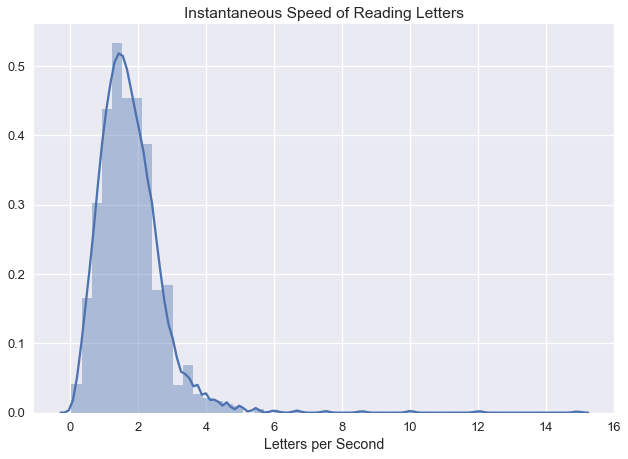

In [395]:
proportion = 0.99
letters_per_second.sort()
plt.title('Instantaneous Speed of Reading Letters')
plt.xlabel('Letters per Second')
sns.distplot(letters_per_second[:-int(len(letters_per_second) * (1 - proportion))])
# plt.savefig('speed_histogram.png', dpi=300)

In [356]:
avg_median_stdev_skewness(letters_per_second)

Average 2.0174754054728647
Median 1.6233766233766234
St.Dev 2.958058101263824
Skewness 11.184084977396179


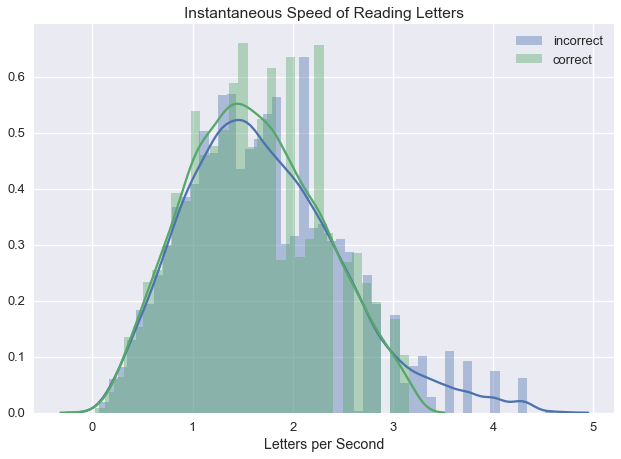

In [488]:
plt.title('Instantaneous Speed of Reading Letters')
plt.xlabel('Letters per Second')
letters_per_second0.sort()
sns.distplot(letters_per_second0[:-500], label='incorrect')
letters_per_second1.sort()
sns.distplot(letters_per_second1[:-500], label='correct')
plt.legend()
plt.savefig('speed_histogram_solved.png', dpi=300)

In [486]:
avg_median_stdev_skewness(letters_per_second0)

Average 2.035399560645174
Median 1.6666666666666667
St.Dev 2.9952652246115026
Skewness 10.829926596532523


In [487]:
avg_median_stdev_skewness(letters_per_second1)

Average 1.9724586978077772
Median 1.6233766233766234
St.Dev 2.862153592568486
Skewness 12.17862364437537


In [480]:
print(len(letters_per_second1))

2188


In [436]:
# get the dwell durations on the letters in a variety of lists

dwell_durations = list()
dwell_durations0 = list()  # incorrect
dwell_durations1 = list()  # correct
dwell_durations5 = list()  # five letter
dwell_durations6 = list()  # six letter
num_list = list()
sequence_dwell_2d = list()
for row in sequence_2d_time: 
    standing_num = row[2][0]
    start_time = 0
    end_time = 0
    sequence_dwell_2d_one = [row[0]]
    sequence_2d_one_sequence = list()
    sequence_2d_one_sequence_num = list()
    for i in range(len(row[2])):
        if row[2][i] != standing_num:
            end_time = row[1][i]
            if standing_num != 0:
                # if six letter word
                if len(row[0]) == 10:
                    dwell_durations6.append(end_time - start_time)
                # if five letter word
                if len(row[0]) == 9:
                    dwell_durations5.append(end_time - start_time)
                if row[3] == 0:
                    dwell_durations0.append(end_time - start_time)
                if row[3] == 1:
                    dwell_durations1.append(end_time - start_time)
                dwell_durations.append(end_time - start_time)
                sequence_2d_one_sequence.append(end_time - start_time)
                sequence_2d_one_sequence_num.append(standing_num)
                num_list.append(standing_num)  # debugging
            if row[2][i] != 0:
                start_time = row[1][i]
            standing_num = row[2][i]
    sequence_dwell_2d_one.append(sequence_2d_one_sequence)
    sequence_dwell_2d_one.append(sequence_2d_one_sequence_num)
    sequence_dwell_2d.append(sequence_dwell_2d_one)
    
            

In [440]:
len(sequence_dwell_2d)

202

In [442]:
median_dwell_per_participant_word = list()
median_dwell_per_participant_word0 = list()
median_dwell_per_participant_word1 = list()

for i in range(len(sequence_dwell_2d)):
    median_dwell_per_participant_word.append(statistics.median(sequence_dwell_2d[i][1]))
    if solved_list[i] == 0:
        median_dwell_per_participant_word0.append(statistics.median(sequence_dwell_2d[i][1]))
    if solved_list[i] == 1:
        median_dwell_per_participant_word1.append(statistics.median(sequence_dwell_2d[i][1]))


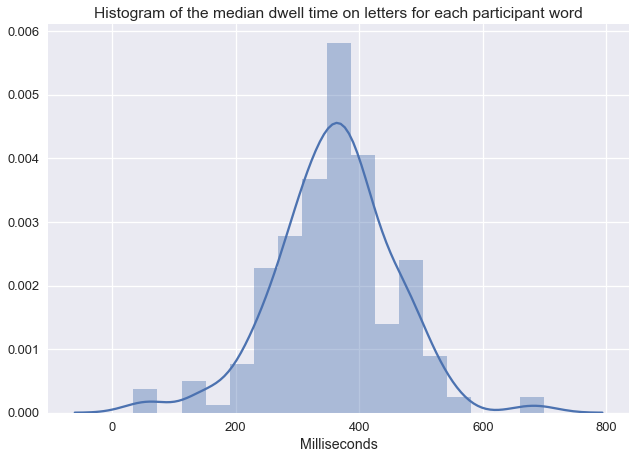

In [312]:
plt.title('Histogram of the median dwell time on letters for each participant word')
plt.xlabel('Milliseconds')
sns.distplot(median_dwell_per_participant_word)

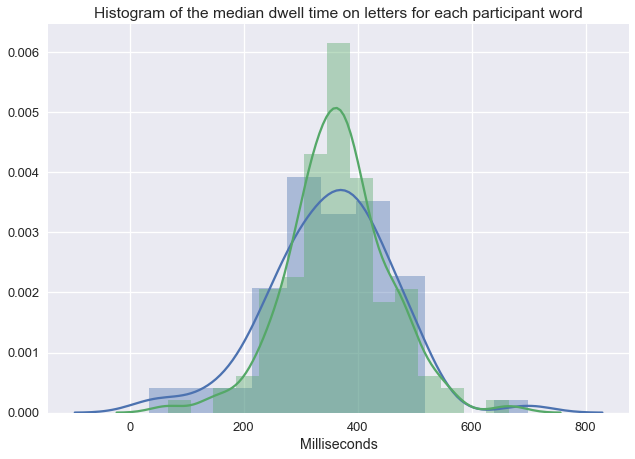

In [443]:
plt.title('Histogram of the median dwell time on letters for each participant word')
plt.xlabel('Milliseconds')
sns.distplot(median_dwell_per_participant_word0)
sns.distplot(median_dwell_per_participant_word1)

In [313]:
avg_median_stdev_skewness(median_dwell_per_participant_word)

Average 360.04455445544556
Median 366.0
St.Dev 96.36538051727038
Skewness -0.1609388404910743


In [299]:
proportion = 0.99

In [300]:
# # plt.xlim(-2,5)
# dwell_durations.sort()
# sns.kdeplot(dwell_durations[-int(len(dwell_durations) * (1 - proportion)):], shade=True)

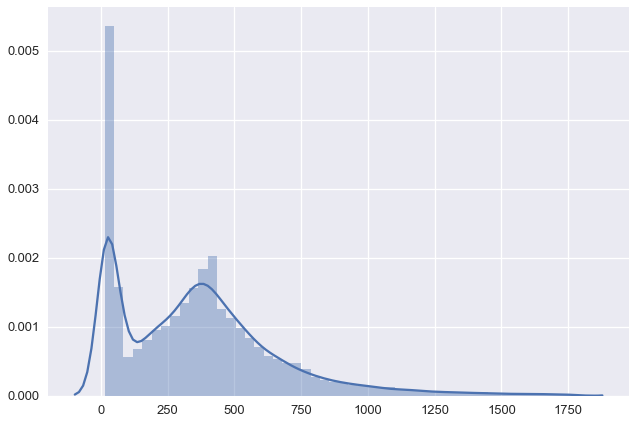

In [301]:
dwell_durations.sort()
sns.distplot(dwell_durations[:-int(len(dwell_durations) * (1 - proportion))])

In [199]:
avg_median_stdev_skewness(dwell_durations)

Average 0.3892423663243361
Median 0.3499999999999943
St.Dev 0.3831238747740264
Skewness 3.630283563965508


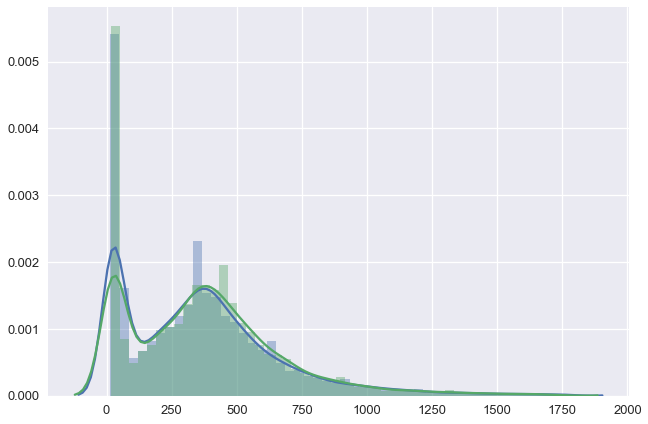

In [439]:
dwell_durations0.sort()
sns.distplot(dwell_durations0[:-int(len(dwell_durations0) * (1 - proportion))])
dwell_durations1.sort()
sns.distplot(dwell_durations1[:-int(len(dwell_durations1) * (1 - proportion))])

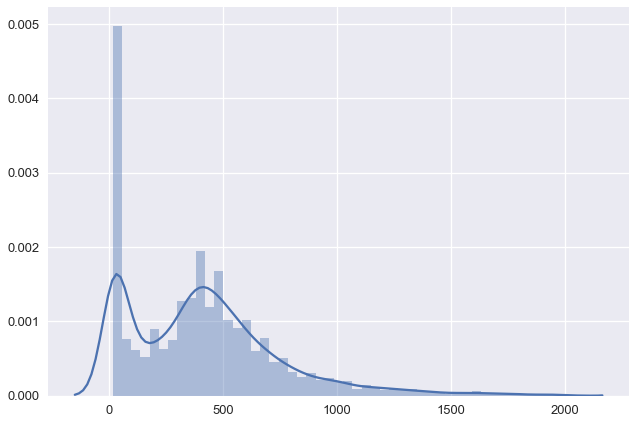

In [351]:
dwell_durations5.sort()
sns.distplot(dwell_durations5[:-int(len(dwell_durations5) * (1 - proportion))])

In [352]:
avg_median_stdev_skewness(dwell_durations5)

Average 440.7263449065242
Median 399.0
St.Dev 423.89239074550625
Skewness 3.1108164897121577


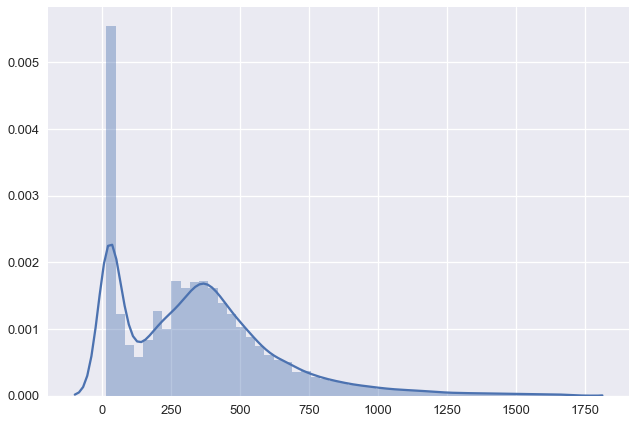

In [350]:
dwell_durations6.sort()
sns.distplot(dwell_durations6[:-int(len(dwell_durations6) * (1 - proportion))])

In [353]:
avg_median_stdev_skewness(dwell_durations6)

Average 372.85726428267867
Median 333.0
St.Dev 367.7037655814141
Skewness 3.851992420352876


In [104]:
for index in np.argsort(dwell_durations)[-10:]:
    print(num_list[index], dwell_durations[index])

2.0 5.496000000000002
5.0 5.663000000000004
4.0 5.6789999999999985
1.0 5.713000000000008
4.0 5.795999999999999
6.0 6.0120000000000005
4.0 6.062000000000012
4.0 6.744999999999976
5.0 6.844999999999999
1.0 7.777000000000001


In [192]:
assert(len(dwell_durations) == len(dwell_durations5) + len(dwell_durations6))

In [252]:
R5 = 143

radius = 0
radius_list = list()
confidence_level_list = list()
confidence_level = 1
while radius <= 2 * R5:
    x = (radius - R5) * (4 / 100) - .9
    confidence_level = 1 / (1 + m.exp(x))
    # - ((radius / R5) - R5))
    radius_list.append(radius)
    confidence_level_list.append(confidence_level)
    radius += 0.1
    

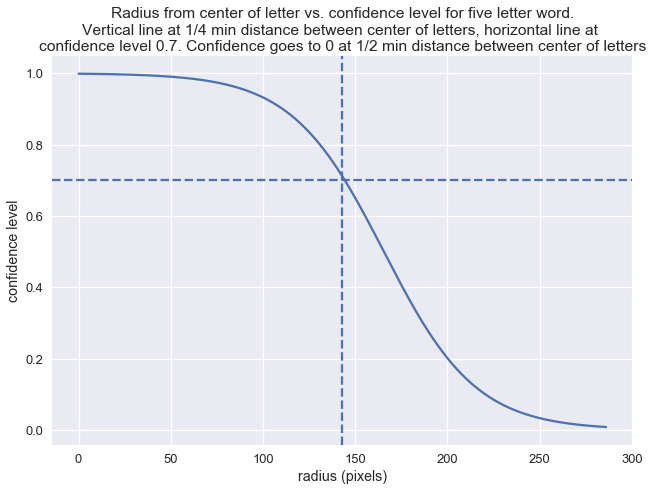

In [263]:
plt.title('Radius from center of letter vs. confidence level for five letter word.\n\
Vertical line at 1/4 min distance between center of letters, horizontal line at \n\
confidence level 0.7. Confidence goes to 0 at 1/2 min distance between center of letters')
plt.xlabel('radius (pixels)')
plt.ylabel('confidence level')
plt.plot(radius_list, confidence_level_list)
plt.axvline(x=R5, linestyle='--')
plt.axhline(y=0.7, linestyle='--')
# plt.savefig('confidence_level.png', dpi=300)